In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import get_dataset_df_from_file as get_world_dataset_df_from_file

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch the latest data

If the interface is overloaded, the collector will retry every few seconds.

In [4]:
df, states_in_order = get_dataset_df()
fns = save_data(df, states_in_order)
print("data saved to {} and {}".format(*fns))

           positive       negative       pending  hospitalized       death  \
count   1313.000000    1175.000000    421.000000    230.000000  638.000000   
mean     540.233816    3363.237447    852.194774    342.408696   16.716301   
std     3127.878578    8860.887747   6410.150756   1305.434977   60.564374   
min        0.000000       0.000000     -3.000000      0.000000    0.000000   
25%        5.000000      83.000000      4.000000     13.250000    1.000000   
50%       37.000000     385.000000     20.000000     53.500000    3.000000   
75%      206.000000    2591.000000     88.000000    156.000000   10.000000   
max    59513.000000  112847.000000  64400.000000  12075.000000  965.000000   

               total  totalTestResults  deathIncrease  hospitalizedIncrease  \
count    1317.000000       1317.000000    1261.000000           1261.000000   
mean     3811.621109       3539.203493       1.926249             15.699445   
std     12171.400530      11222.986291      11.333758       

### Fetch data set from local disk

In [5]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-03-24_1744_state_daily_data.csv 2020-03-26_2303_state_rank.csv
2020-03-24_1744_state_rank.csv       2020-03-27_0119_state_daily_data.csv
2020-03-24_1829_state_daily_data.csv 2020-03-27_0119_state_rank.csv
2020-03-24_1829_state_rank.csv       2020-03-27_0124_state_daily_data.csv
2020-03-24_2013_state_daily_data.csv 2020-03-27_0124_state_rank.csv
2020-03-24_2013_state_rank.csv       2020-03-27_1459_state_daily_data.csv
2020-03-24_2046_state_daily_data.csv 2020-03-27_1459_state_rank.csv
2020-03-24_2046_state_rank.csv       2020-03-27_1911_state_daily_data.csv
2020-03-24_2359_state_daily_data.csv 2020-03-27_1911_state_rank.csv
2020-03-24_2359_state_rank.csv       2020-03-27_1933_state_daily_data.csv
2020-03-25_0000_state_daily_data.csv 2020-03-27_1933_state_rank.csv
2020-03-25_0000_state_rank.csv       2020-03-27_1959_state_daily_data.csv
2020-03-25_1516_state_daily_data.csv 2020-03-27_1959_state_rank.csv
2020-03-25_1516_state_rank.csv       2020-03-27_2230_state_daily_data.csv
2020-0

In [6]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,order,lastUpdateEt
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,78,1afd6e025157a38728847bbf42145c63b024c387,2020-03-04 21:00:00+00:00,54,36,NaN,NaN,NaN,NaN,NaN,0,2020-03-29 09:16:00
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,122,25c15099a4116ff026c04c0b4a6b3780ccba310b,2020-03-05 21:00:00+00:00,98,36,0.0,0.0,28.0,16.0,44.0,0,2020-03-29 09:16:00
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,361,1bd1fecfd3d23311c604ac6c27d05ce5835af2c5,2020-03-06 21:00:00+00:00,125,36,0.0,0.0,16.0,11.0,27.0,0,2020-03-29 09:16:00
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,404,d9b32dfe41c22decc86fe0a35515525a18b68fa9,2020-03-07 21:00:00+00:00,168,36,0.0,0.0,0.0,43.0,43.0,0,2020-03-29 09:16:00
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,197,22912a8c6cdefd796b1412292c796959a8cc088f,2020-03-08 20:00:00+00:00,197,36,0.0,0.0,0.0,29.0,29.0,0,2020-03-29 09:16:00


### Zero-day normalized log plots

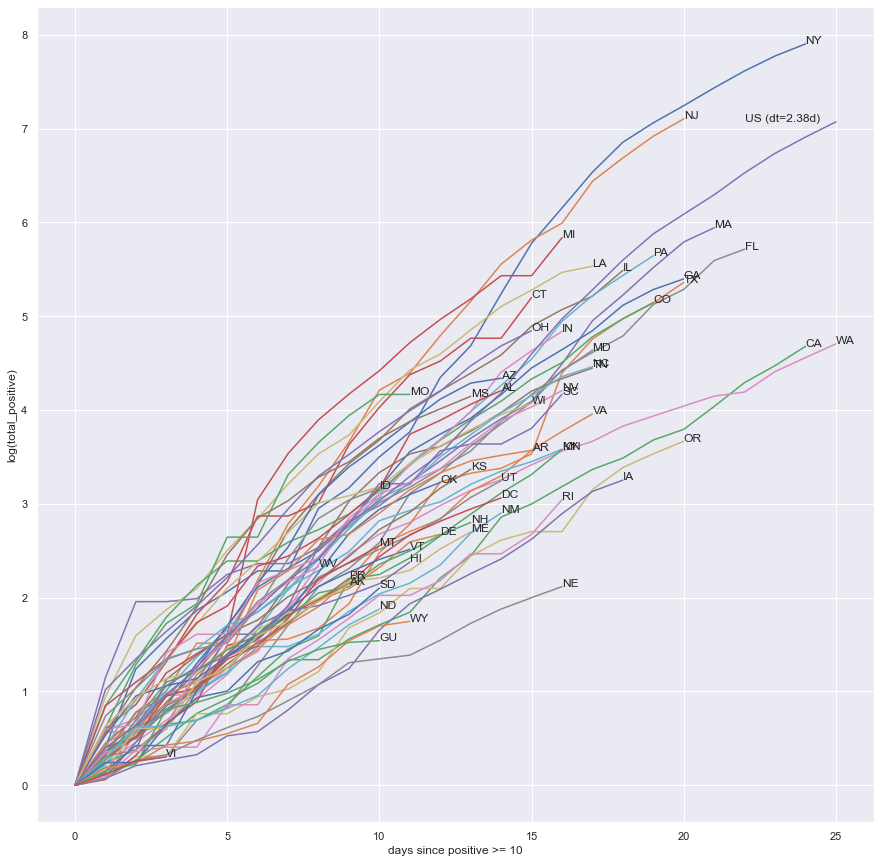

In [7]:
# start after day with min_pos or more cases
min_pos = 10
last_n_days = None

# image
plt.figure(figsize=[15,15])

# state by state
for s in states_in_order:
    try:
        dfq, dt, lud = get_state_doubling_df(df, s, zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
        plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
        plt.annotate(s, (dfq["days_since_{}".format(min_pos)].values[-1], dfq.log_positive.values[-1]))
    except IndexError:
        pass

# All US image
try:
    dfq, dt, lud = get_state_doubling_df(df, "*", zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
    plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
    xus = int(.9* dfq["days_since_{}".format(min_pos)].values[-1])
    plt.annotate("US (dt={:1.2f}d)".format(dt), (xus , dfq.log_positive.values[-1]))
except IndexError:
    pass

plt.xlabel("days since positive >= {}".format(min_pos))
plt.ylabel("log(total_positive)")
plt.show()

### US Totals and Doubling Times

US Total Positive, doubling every 2.52 days
  as of 2020-03-29T16:00
  based on last 14 days of data


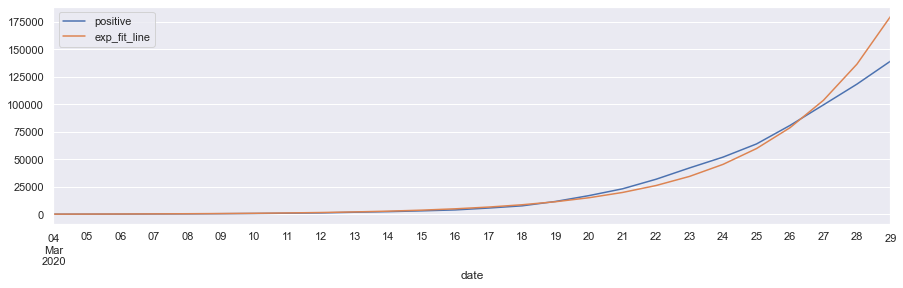

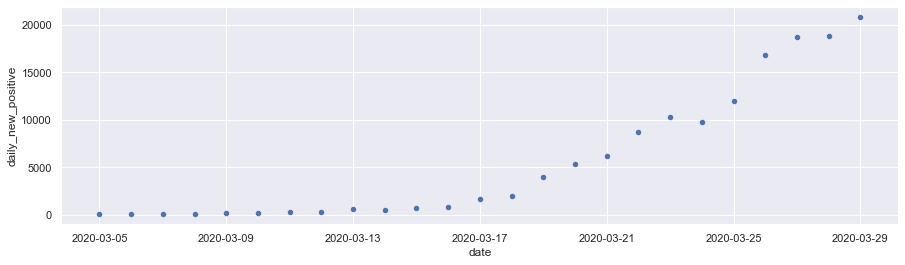

In [8]:
last_n_days = 14
dfa, dt, lud = get_state_doubling_df(df, "*", use_last_n_days=last_n_days)
lu = str(lud)[:16]
print("US Total Positive, doubling every {:.3} days\n  as of {}".format(dt, lu))
print("  based on last {} days of data".format(last_n_days))
dfa.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
dfa.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
plt.show()

### Testing

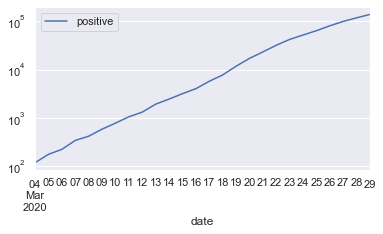

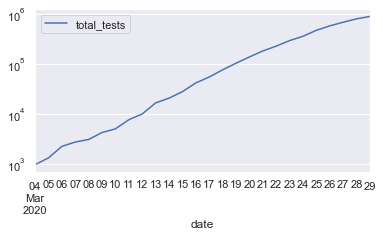

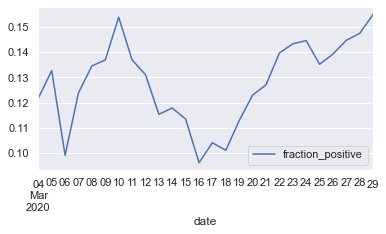

In [9]:
dfs, _ = get_state_df(df, "*")
dfs.head()
dfs["total_tests"] = dfs["positive"] + dfs["negative"] + dfs["pending"]
dfs["fraction_positive"] = dfs["positive"]/ dfs["total_tests"]
dfa.plot(x="date", y="positive", logy=True, figsize=[6,3])
dfs.plot("date", "total_tests", logy=True, figsize=[6,3])
dfs.plot("date", "fraction_positive", figsize=[6,3])

### Current measured ratios and percentages

These are based on cases that test postive and test negative (state labs policies vary on this).

In [10]:
print("Current strategies for diagnosis give pos/neg tests ratio of {:.1%}".format(
    df.positive.sum()/(df.positive.sum() + df.negative.sum())))
print("on total tests tracked = {:,}".format(int(df.positive.sum() + df.negative.sum())))

Current strategies for diagnosis give pos/neg tests ratio of 15.2%
on total tests tracked = 4,661,131


In [11]:
pos_dr = df.death.sum()/df.positive.sum()
print("Current death/positive ratio of {:.1%}".format(pos_dr))

Current death/positive ratio of 1.5%


In [12]:
# projections of exp growth
print("US flu death rate average per week = 61,099/52 ≈ {}".format(int(61099/52)))
print("Using doubling time of {:2.2f} days".format(dt))
print("period      date         positive,     deaths              weekly rate")
print("-------------------------------------------------------------------------------------")
now, v = dfa[-1:][["date", "positive"]].values[0]
start, _ = dfa[1:][["date", "positive"]].values[0]
time_in_weeks = (now - start).total_seconds()/(86400*7)
pstr = "{:4}: {:%Y-%m-%d %H h}, {:10,d} [total deaths {:6,d}] Death Rate Avg = {:,d} per wk"
print(pstr.format(0, now, int(v), int(v*pos_dr), int(v*pos_dr/time_in_weeks)))

ddt = datetime.timedelta(days=dt)
for i in range(1,5):
    t = now + i*ddt
    time_in_weeks = (t - start).total_seconds()/(86400*7)
    v *= 2
    print(pstr.format(i,t,int(v), int(v*pos_dr), int(v*pos_dr/time_in_weeks)))
    

US flu death rate average per week = 61,099/52 ≈ 1174
Using doubling time of 2.52 days
period      date         positive,     deaths              weekly rate
-------------------------------------------------------------------------------------
   0: 2020-03-29 00 h,    139,061 [total deaths  2,090] Death Rate Avg = 609 per wk
   1: 2020-03-31 12 h,    278,122 [total deaths  4,181] Death Rate Avg = 1,103 per wk
   2: 2020-04-03 00 h,    556,244 [total deaths  8,363] Death Rate Avg = 2,016 per wk
   3: 2020-04-05 13 h,  1,112,488 [total deaths 16,726] Death Rate Avg = 3,710 per wk
   4: 2020-04-08 01 h,  2,224,976 [total deaths 33,453] Death Rate Avg = 6,871 per wk


### State Trends and Doubling Periods

State=NY  (last_update=2020-03-29T09:16)
Doubling every 2.2 days based on last 14 days of data
(naive estimates: current_unresolved=55361 hosp=8304 icu=2214)


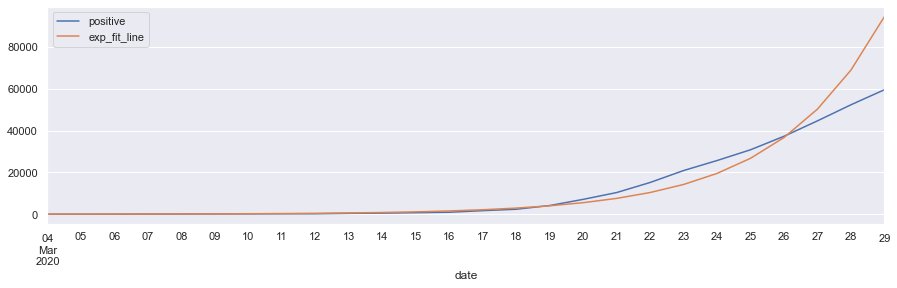

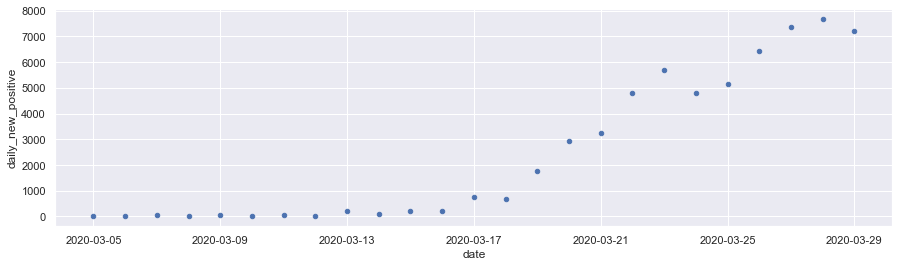

State=NJ  (last_update=2020-03-29T13:30)
Doubling every 2.08 days based on last 14 days of data
(naive estimates: current_unresolved=12644 hosp=1896 icu=505)


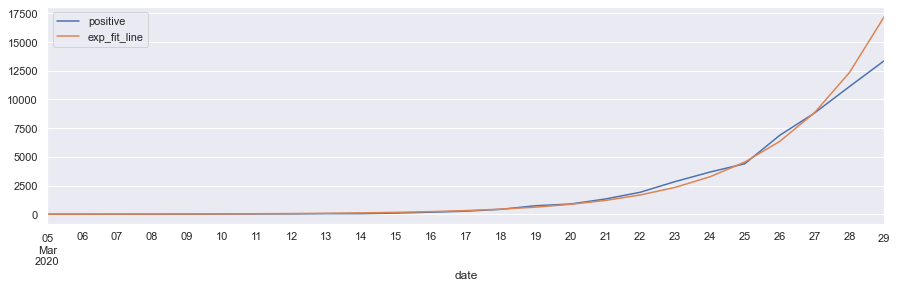

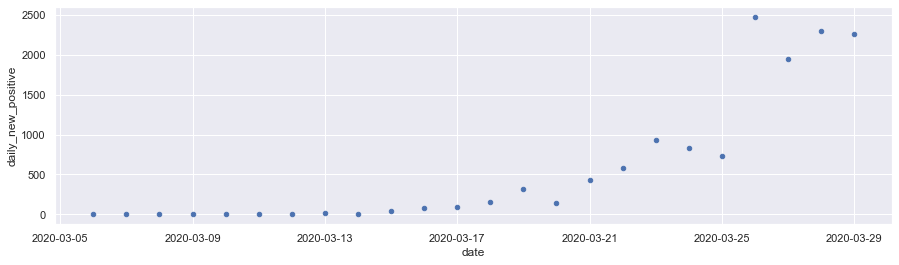

State=CA  (last_update=2020-03-29T14:18)
Doubling every 3.42 days based on last 14 days of data
(naive estimates: current_unresolved=4784 hosp=717 icu=191)


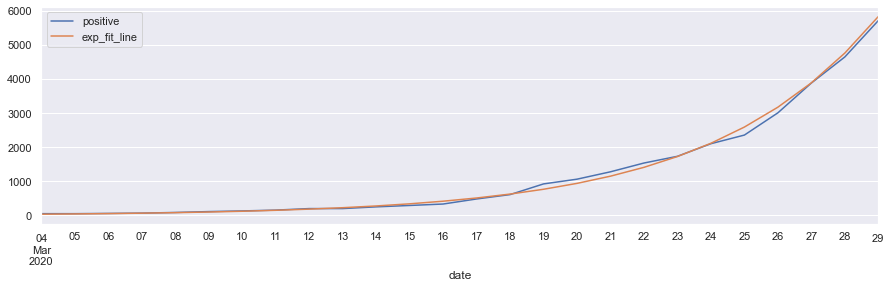

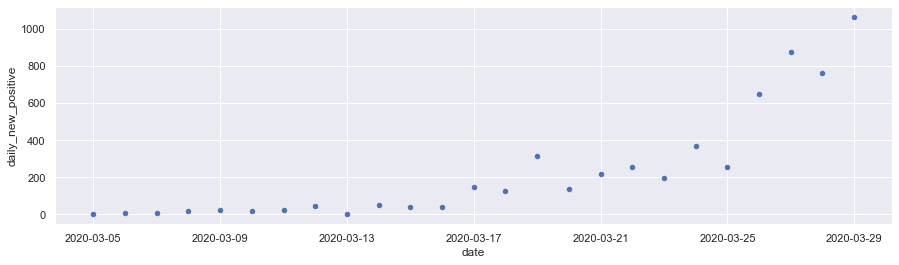

State=MI  (last_update=2020-03-28T14:00)
Doubling every 1.92 days based on last 14 days of data
(naive estimates: current_unresolved=5150 hosp=772 icu=206)


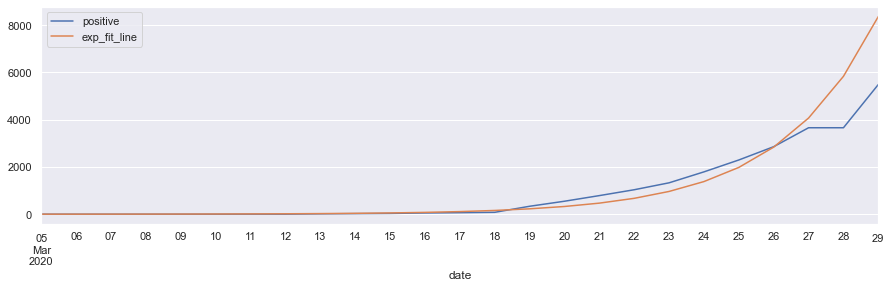

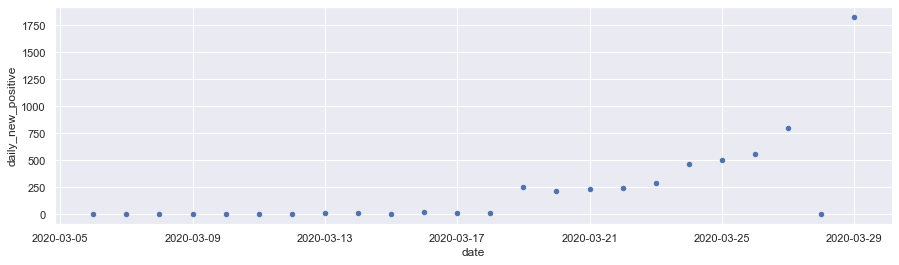

State=MA  (last_update=2020-03-28T12:30)
Doubling every 2.55 days based on last 14 days of data
(naive estimates: current_unresolved=4627 hosp=694 icu=185)


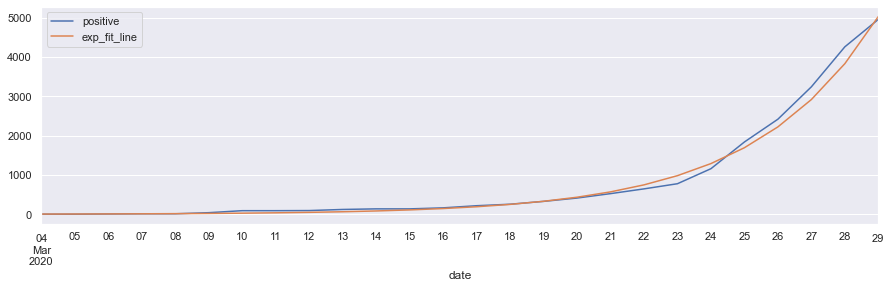

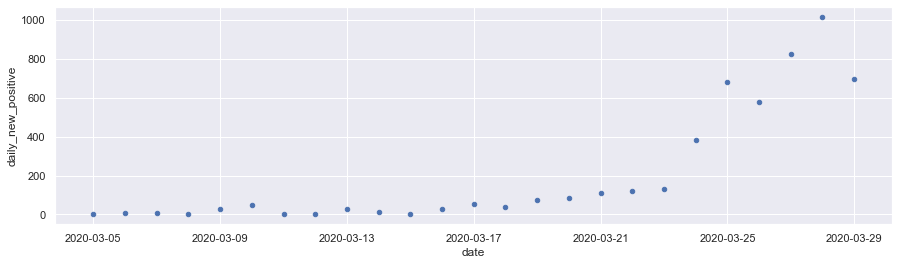

State=IL  (last_update=2020-03-29T00:00)
Doubling every 2.49 days based on last 14 days of data
(naive estimates: current_unresolved=4174 hosp=626 icu=166)


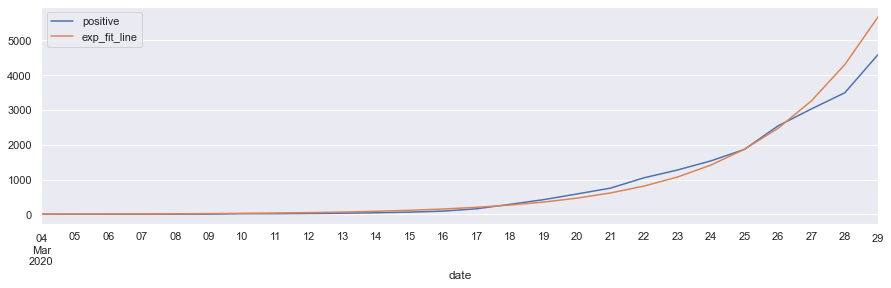

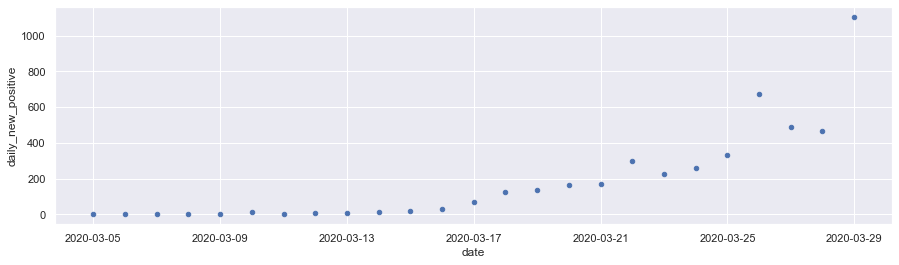

State=WA  (last_update=2020-03-28T02:59)
Doubling every 5.44 days based on last 14 days of data
(naive estimates: current_unresolved=3123 hosp=468 icu=124)


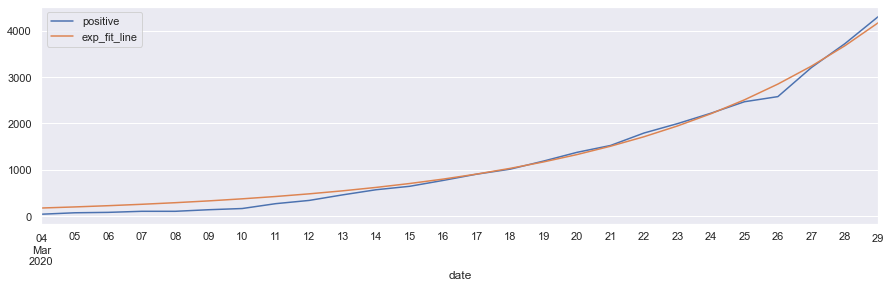

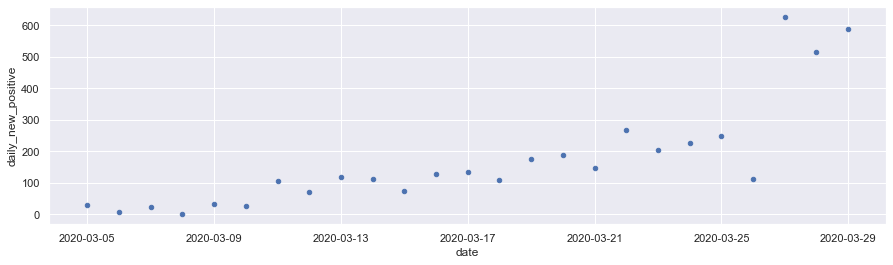

State=FL  (last_update=2020-03-29T11:30)
Doubling every 2.67 days based on last 14 days of data
(naive estimates: current_unresolved=3856 hosp=578 icu=154)


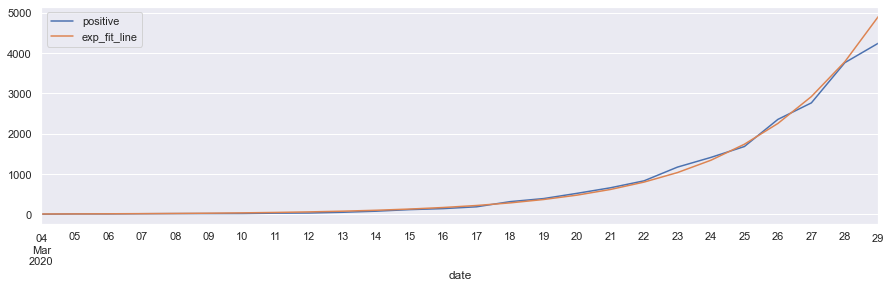

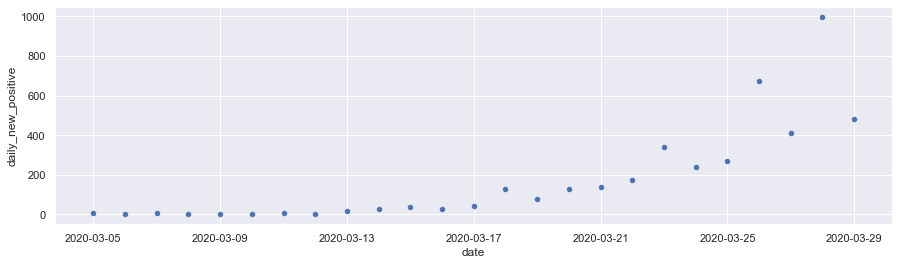

State=LA  (last_update=2020-03-29T13:00)
Doubling every 2.59 days based on last 14 days of data
(naive estimates: current_unresolved=3193 hosp=478 icu=127)


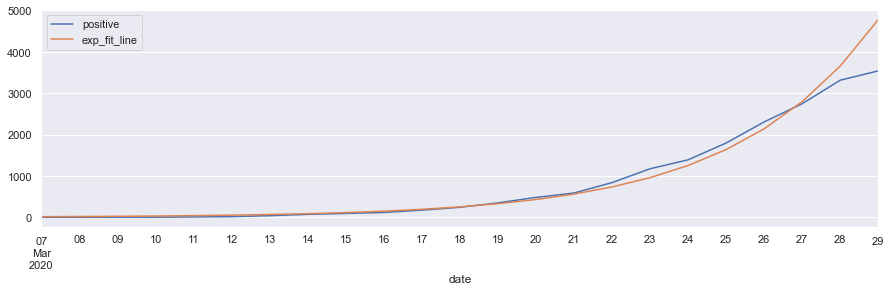

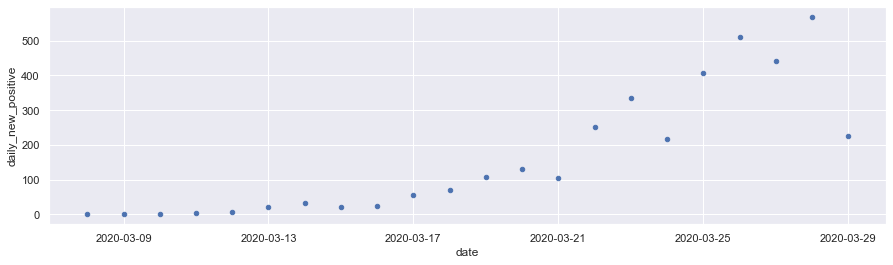

State=PA  (last_update=2020-03-29T12:00)
Doubling every 2.3 days based on last 14 days of data
(naive estimates: current_unresolved=3209 hosp=481 icu=128)


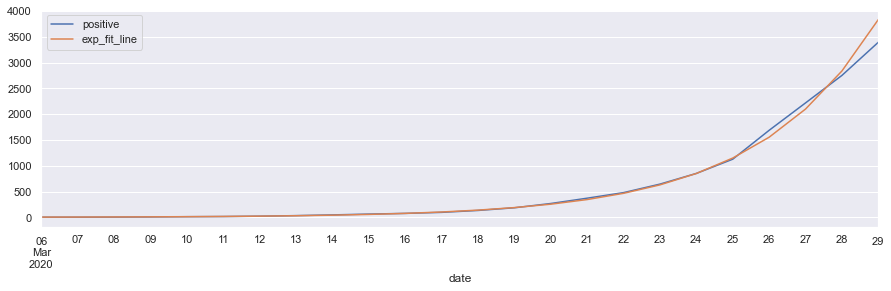

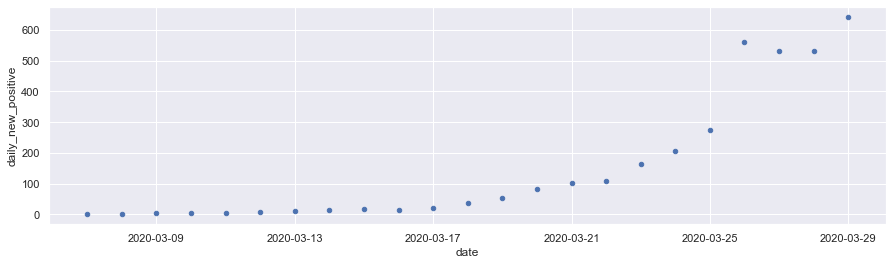

State=GA  (last_update=2020-03-28T18:27)
Doubling every 2.84 days based on last 14 days of data
(naive estimates: current_unresolved=2364 hosp=354 icu=94)


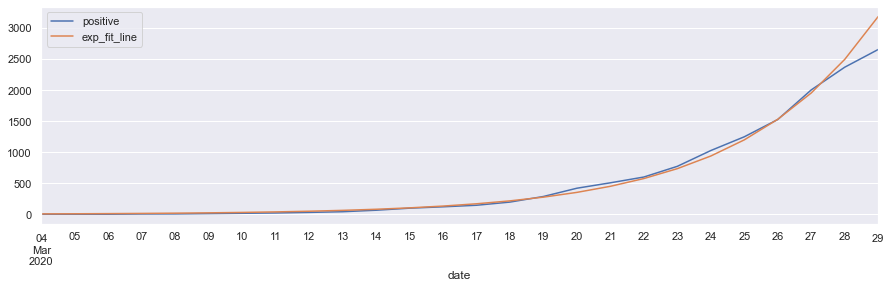

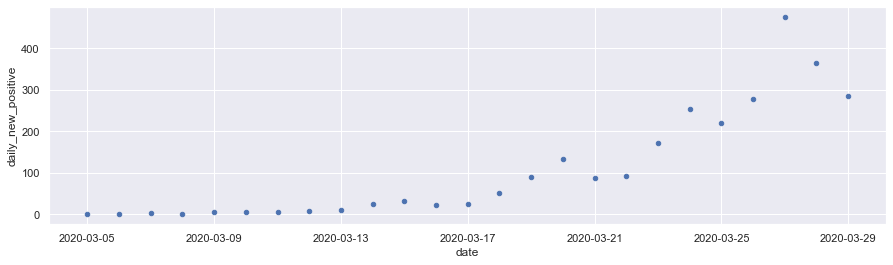

State=TX  (last_update=2020-03-29T13:45)
Doubling every 2.25 days based on last 14 days of data
(naive estimates: current_unresolved=2409 hosp=361 icu=96)


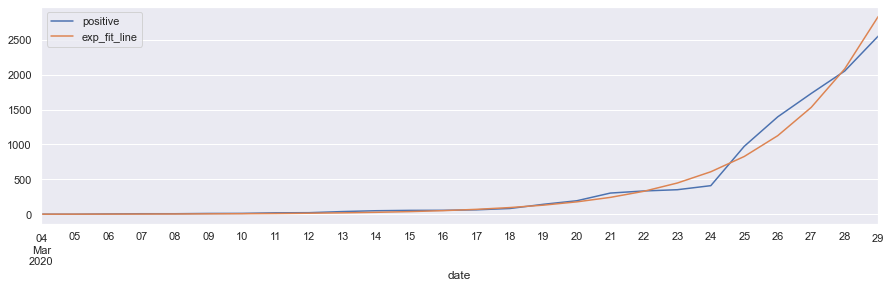

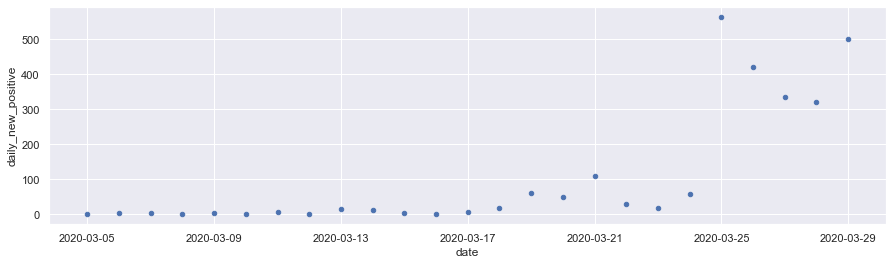

State=CO  (last_update=2020-03-28T18:00)
Doubling every 3.15 days based on last 14 days of data
(naive estimates: current_unresolved=1845 hosp=276 icu=73)


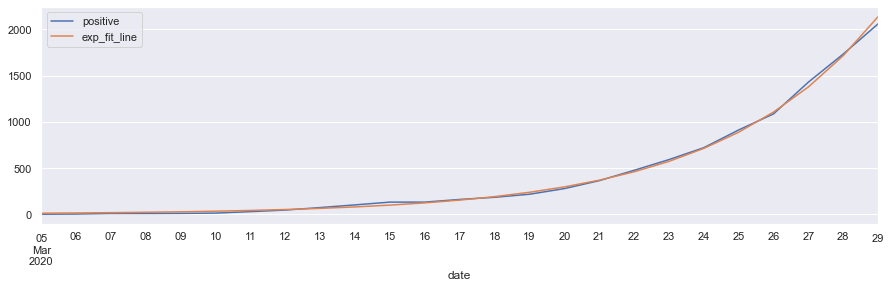

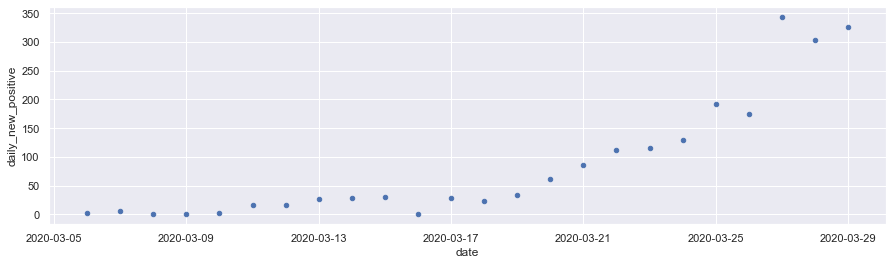

State=CT  (last_update=2020-03-29T12:30)
Doubling every 2.12 days based on last 14 days of data
(naive estimates: current_unresolved=1897 hosp=284 icu=75)


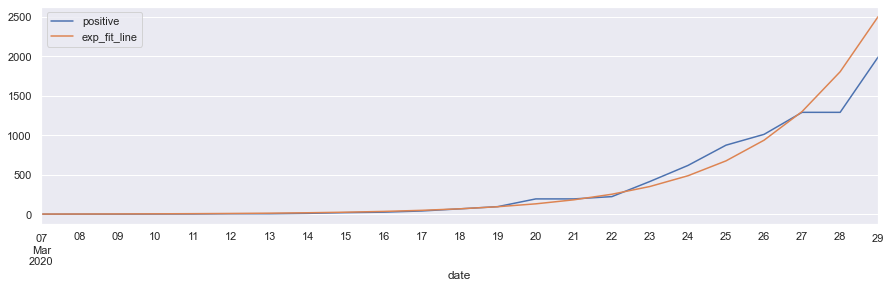

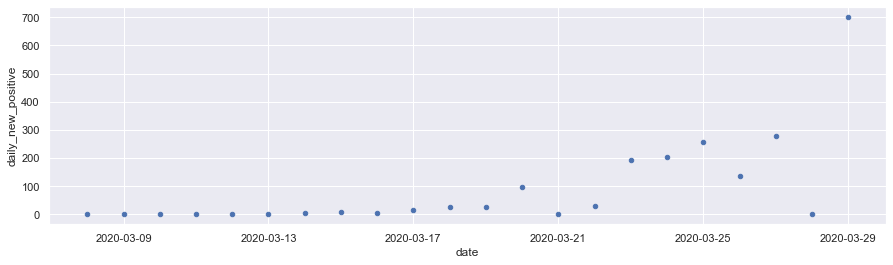

State=OH  (last_update=2020-03-29T14:00)
Doubling every 2.51 days based on last 14 days of data
(naive estimates: current_unresolved=1534 hosp=230 icu=61)


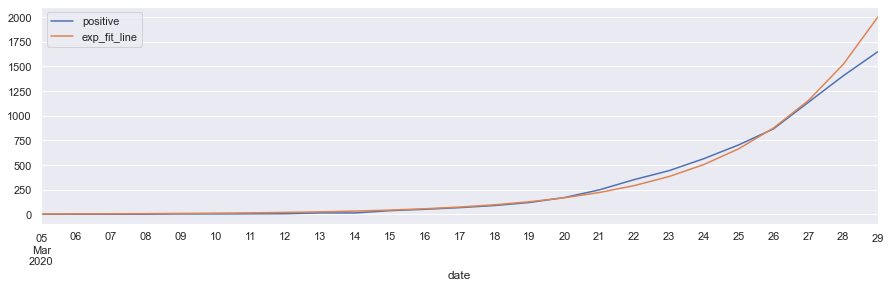

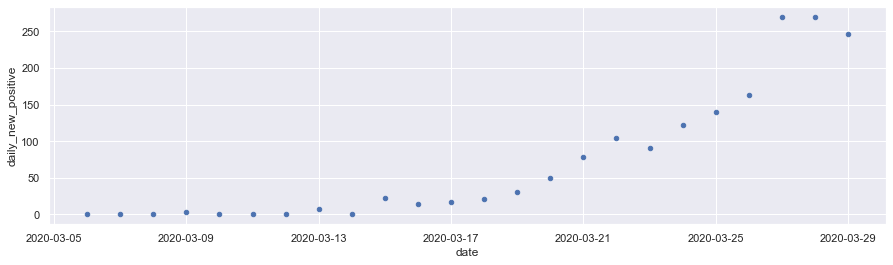

State=TN  (last_update=2020-03-29T15:00)
Doubling every 2.63 days based on last 14 days of data
(naive estimates: current_unresolved=1383 hosp=207 icu=55)


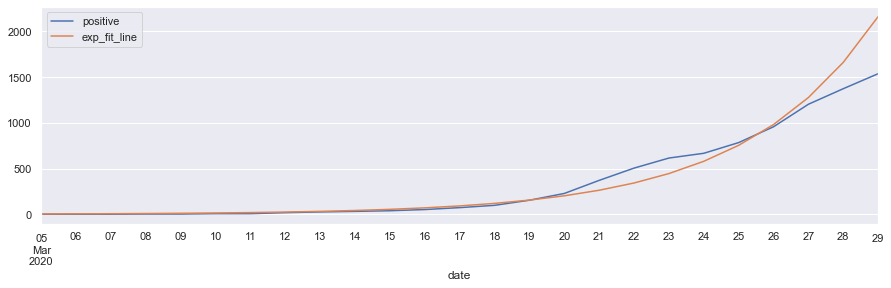

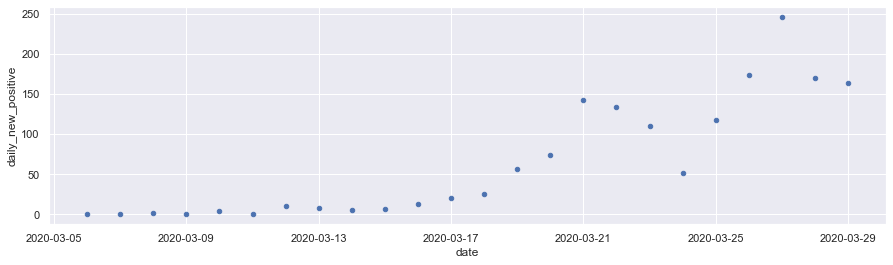

State=IN  (last_update=2020-03-29T11:00)
Doubling every 2.06 days based on last 14 days of data
(naive estimates: current_unresolved=1458 hosp=218 icu=58)


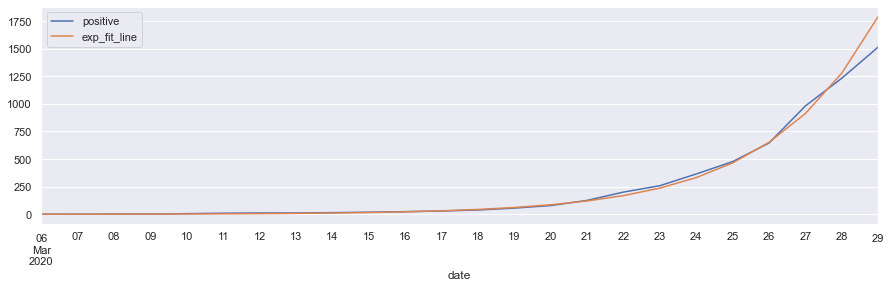

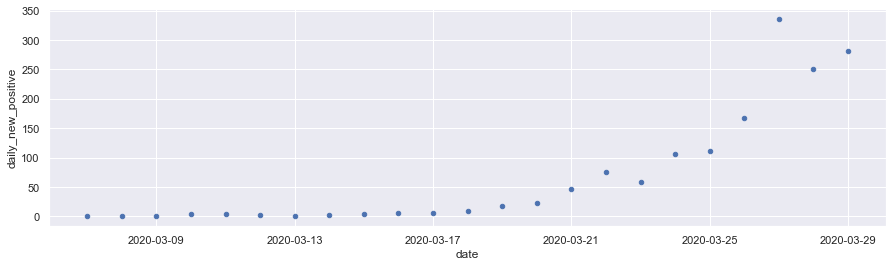

State=MD  (last_update=2020-03-29T10:00)
Doubling every 2.72 days based on last 14 days of data
(naive estimates: current_unresolved=1132 hosp=169 icu=45)


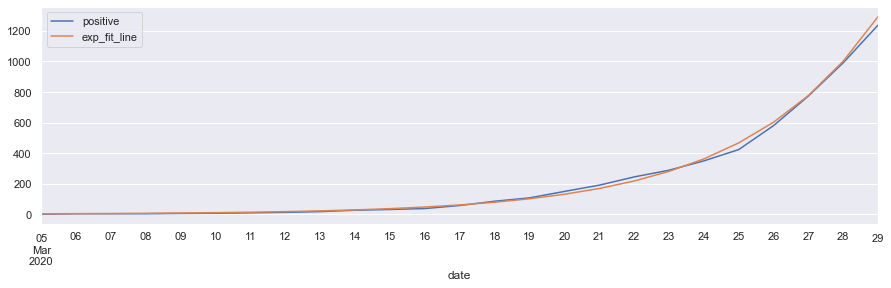

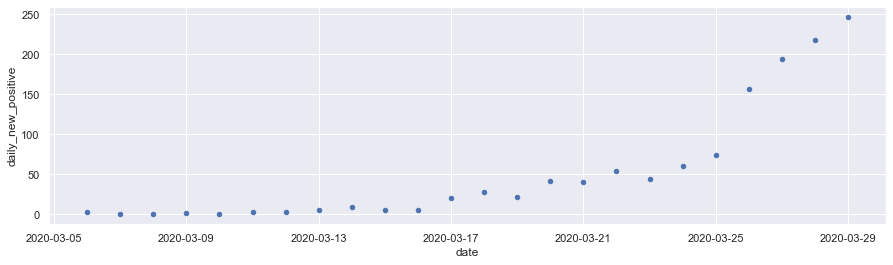

State=WI  (last_update=2020-03-29T16:00)
Doubling every 2.98 days based on last 14 days of data
(naive estimates: current_unresolved=957 hosp=143 icu=38)


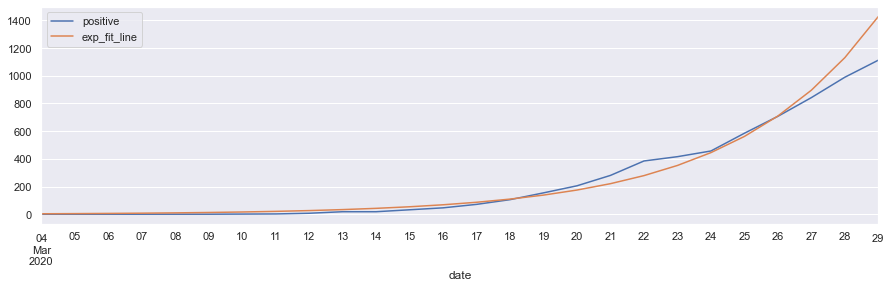

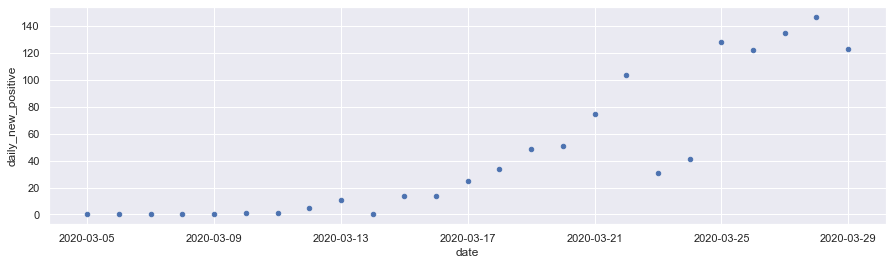

State=NC  (last_update=2020-03-29T10:35)
Doubling every 2.54 days based on last 14 days of data
(naive estimates: current_unresolved=943 hosp=141 icu=37)


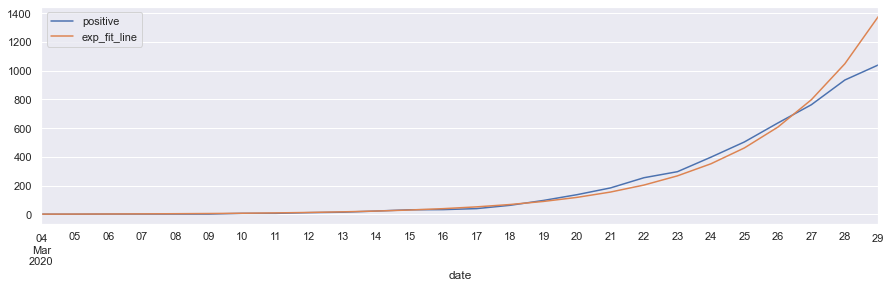

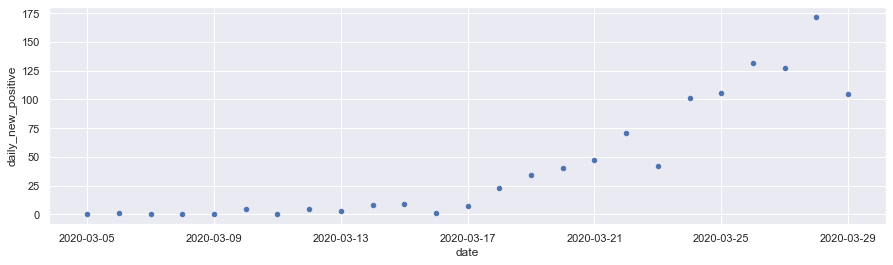

State=AZ  (last_update=2020-03-29T00:00)
Doubling every 2.05 days based on last 14 days of data
(naive estimates: current_unresolved=875 hosp=131 icu=35)


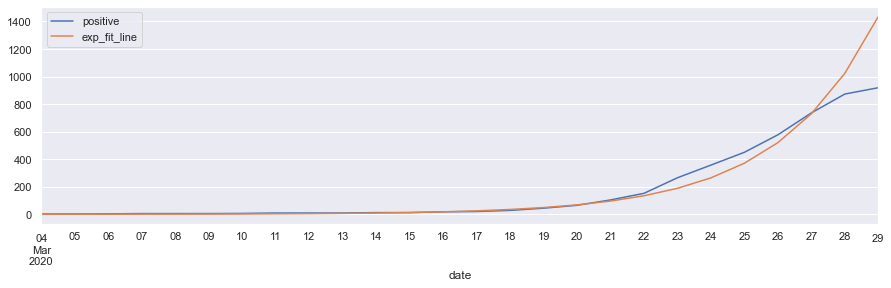

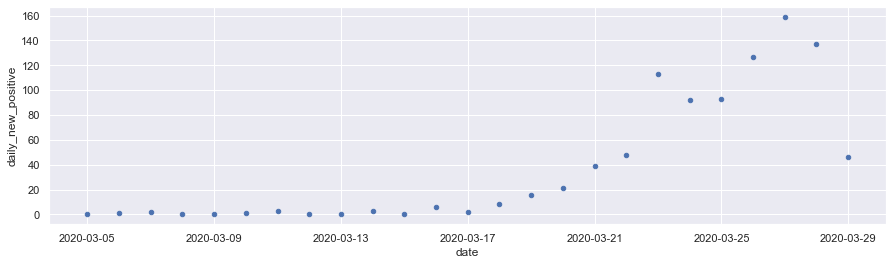

State=VA  (last_update=2020-03-29T00:00)
Doubling every 3.11 days based on last 14 days of data
(naive estimates: current_unresolved=796 hosp=119 icu=31)


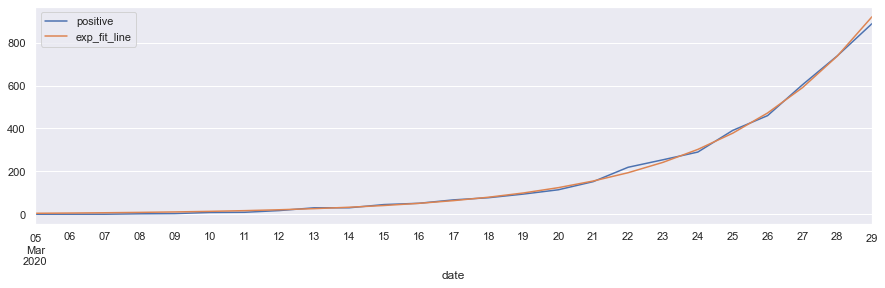

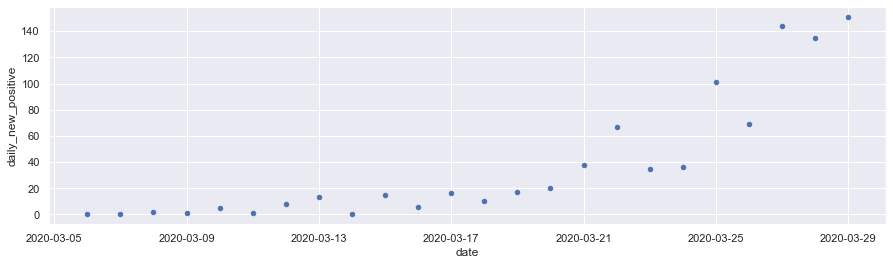

State=MO  (last_update=2020-03-28T15:00)
Doubling every 1.7 days based on last 14 days of data
(naive estimates: current_unresolved=814 hosp=122 icu=32)


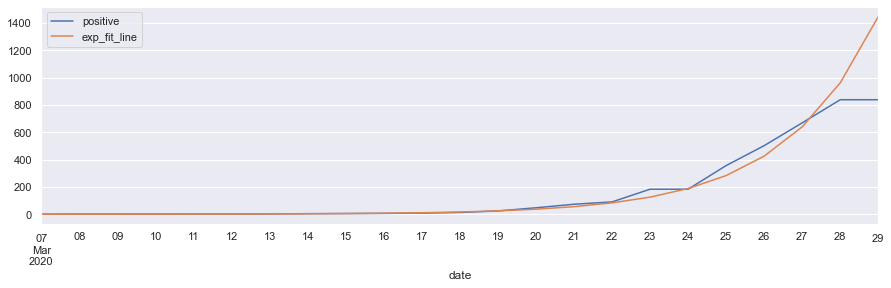

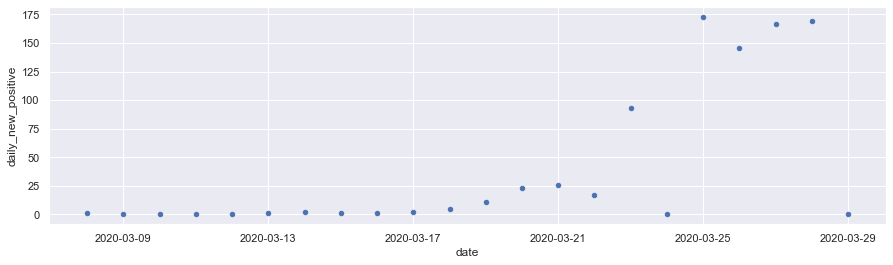

State=AL  (last_update=2020-03-29T00:00)
Doubling every 2.6 days based on last 14 days of data
(naive estimates: current_unresolved=738 hosp=110 icu=29)


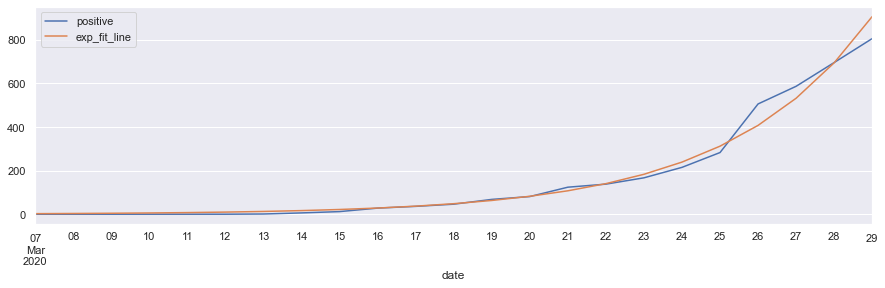

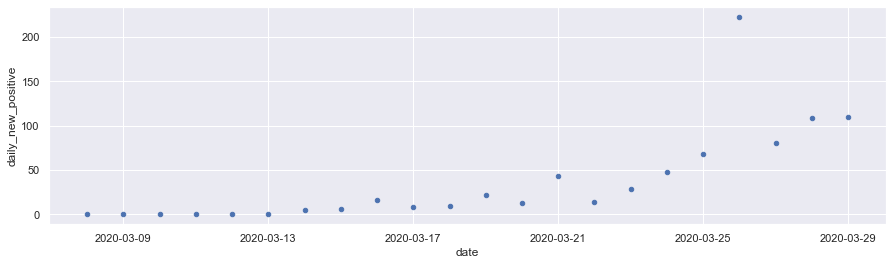

State=SC  (last_update=2020-03-29T15:30)
Doubling every 2.69 days based on last 14 days of data
(naive estimates: current_unresolved=714 hosp=107 icu=28)


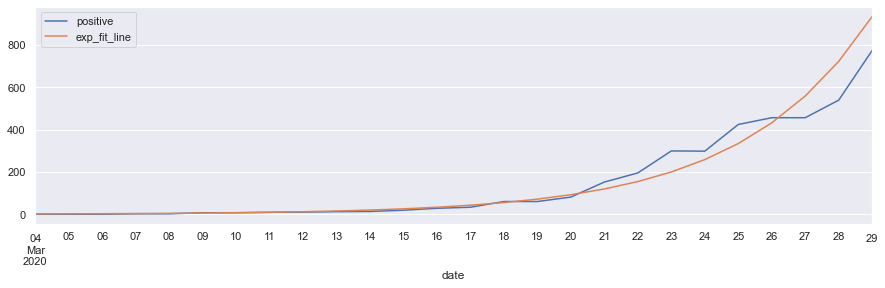

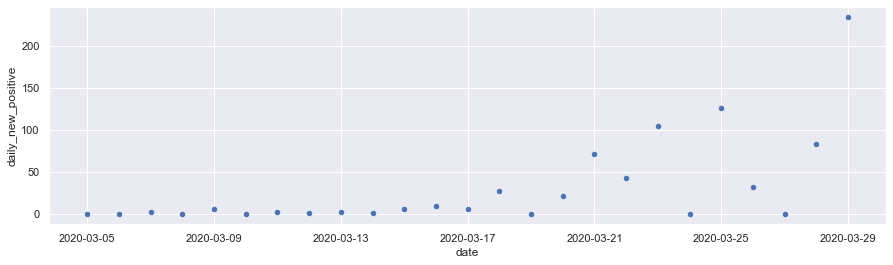

State=MS  (last_update=2020-03-28T19:00)
Doubling every 2.19 days based on last 14 days of data
(naive estimates: current_unresolved=708 hosp=106 icu=28)


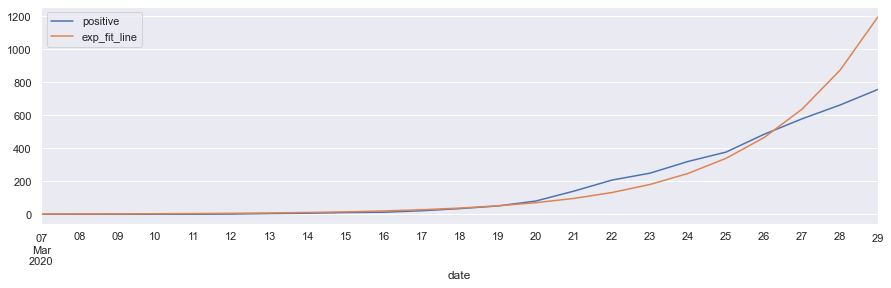

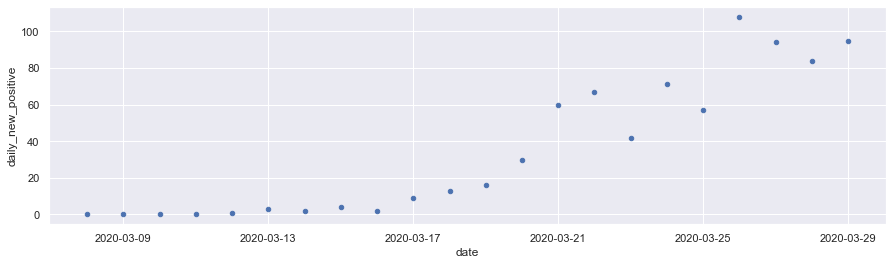

State=NV  (last_update=2020-03-28T21:00)
Doubling every 3.09 days based on last 14 days of data
(naive estimates: current_unresolved=643 hosp=96 icu=25)


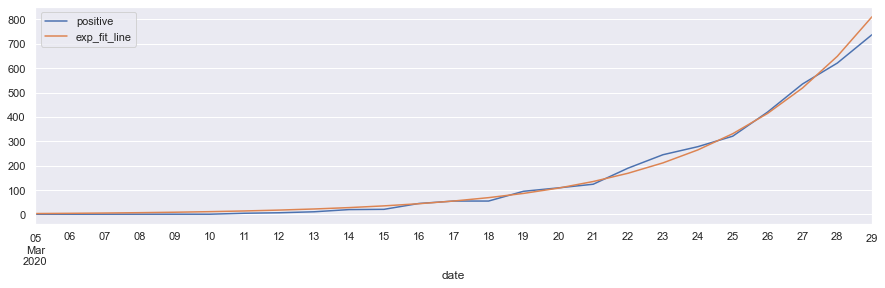

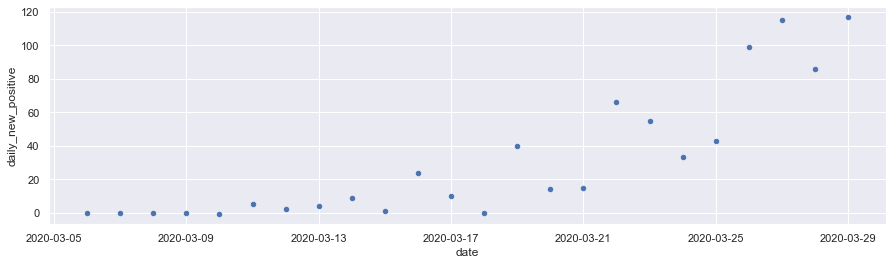

State=UT  (last_update=2020-03-29T15:00)
Doubling every 3.06 days based on last 14 days of data
(naive estimates: current_unresolved=641 hosp=96 icu=25)


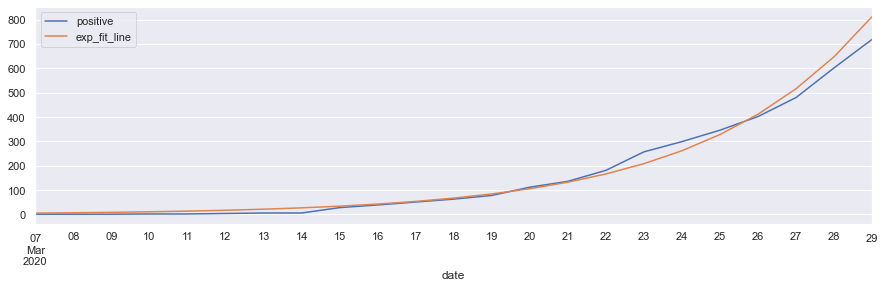

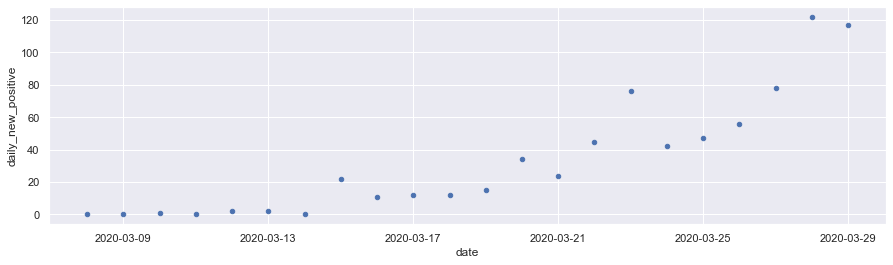

State=OR  (last_update=2020-03-29T11:00)
Doubling every 3.52 days based on last 14 days of data
(naive estimates: current_unresolved=460 hosp=69 icu=18)


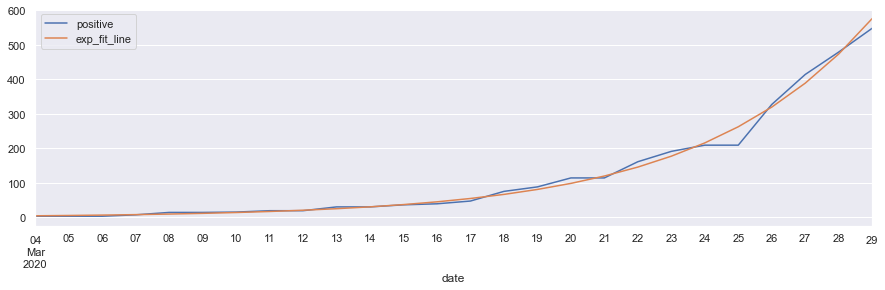

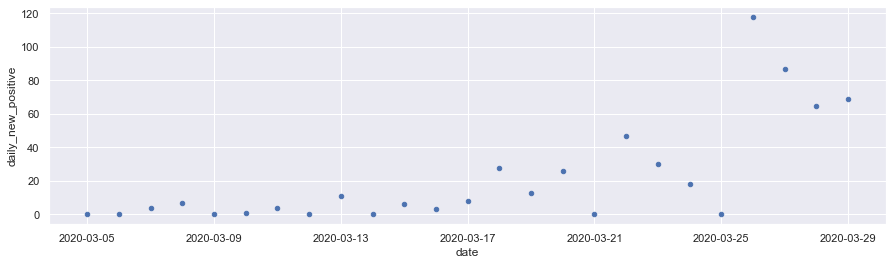

State=MN  (last_update=2020-03-29T00:00)
Doubling every 3.84 days based on last 14 days of data
(naive estimates: current_unresolved=414 hosp=62 icu=16)


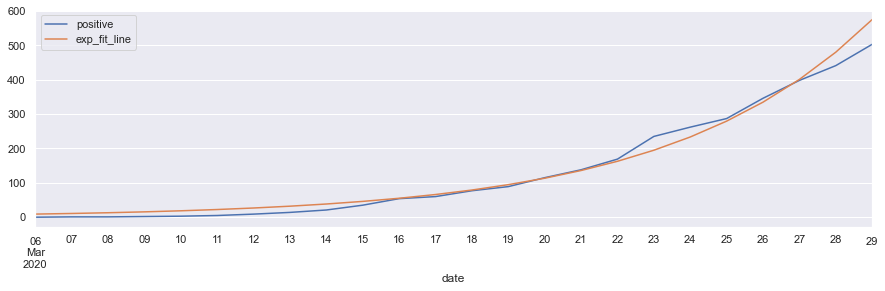

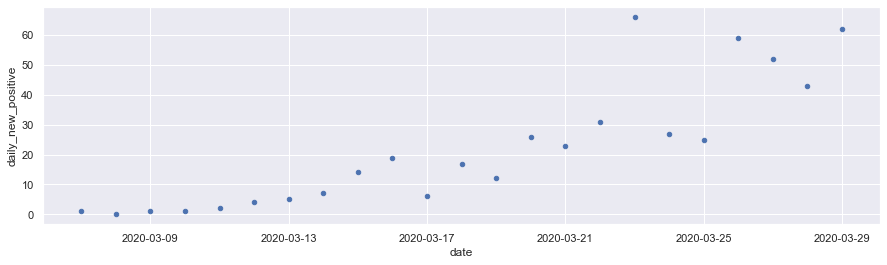

State=OK  (last_update=2020-03-29T08:00)
Doubling every 2.52 days based on last 14 days of data
(naive estimates: current_unresolved=385 hosp=57 icu=15)


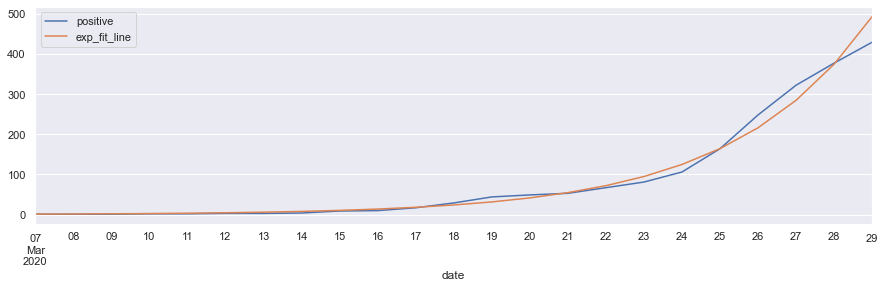

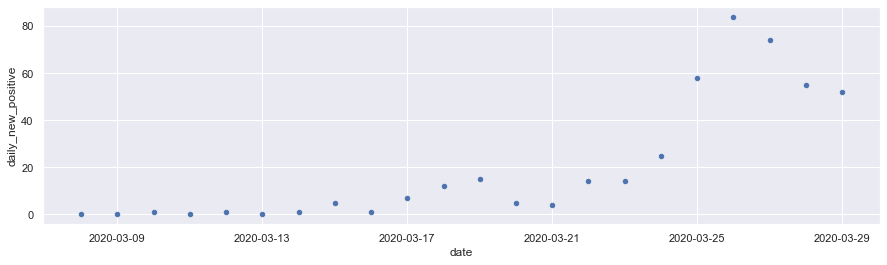

State=AR  (last_update=2020-03-29T11:10)
Doubling every 2.77 days based on last 14 days of data
(naive estimates: current_unresolved=380 hosp=57 icu=15)


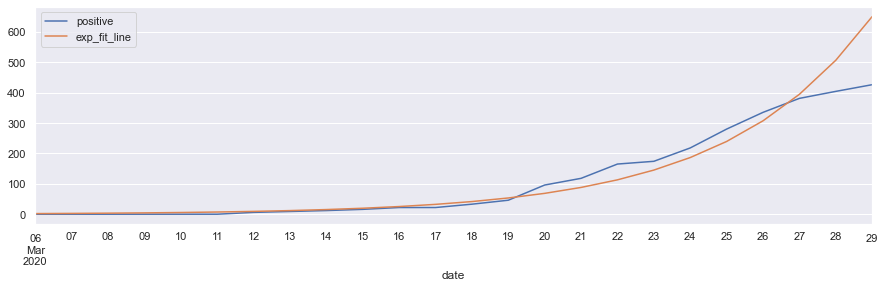

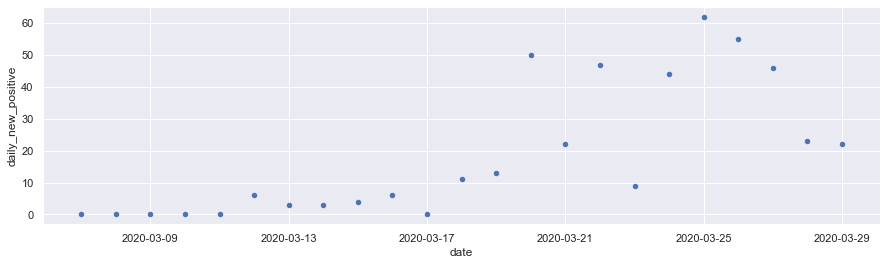

State=KY  (last_update=2020-03-28T17:00)
Doubling every 2.92 days based on last 14 days of data
(naive estimates: current_unresolved=359 hosp=53 icu=14)


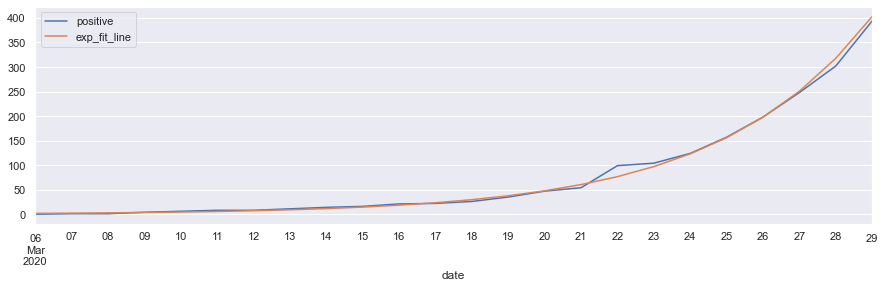

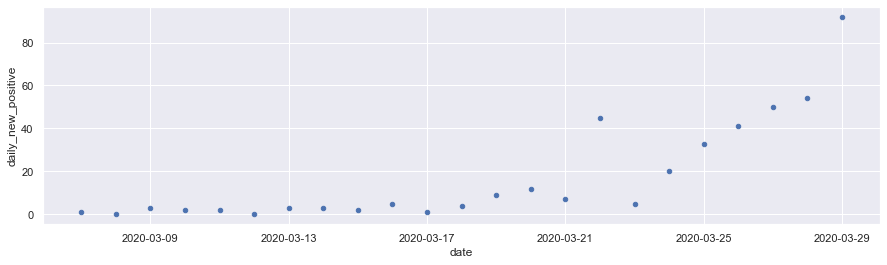

State=DC  (last_update=2020-03-28T19:45)
Doubling every 2.96 days based on last 14 days of data
(naive estimates: current_unresolved=303 hosp=45 icu=12)


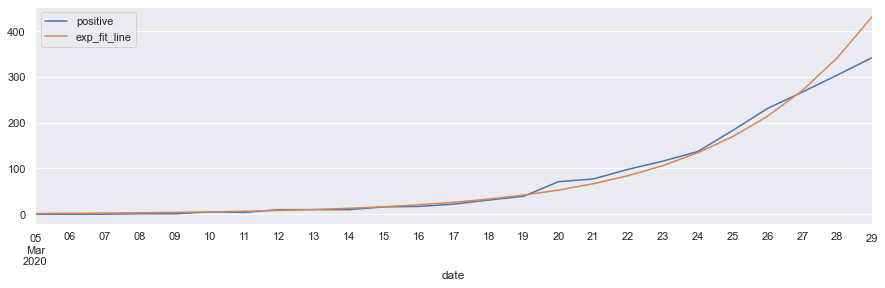

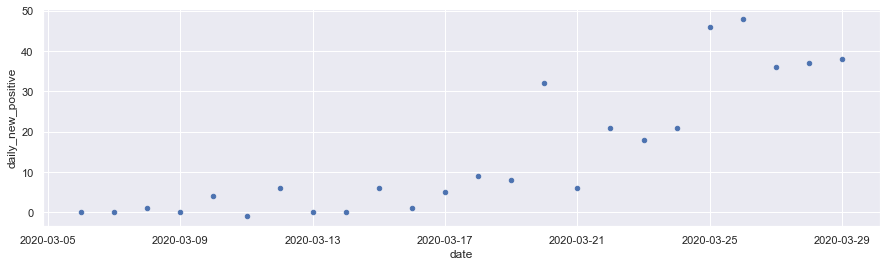

State=IA  (last_update=2020-03-29T00:00)
Doubling every 3.12 days based on last 14 days of data
(naive estimates: current_unresolved=298 hosp=44 icu=11)


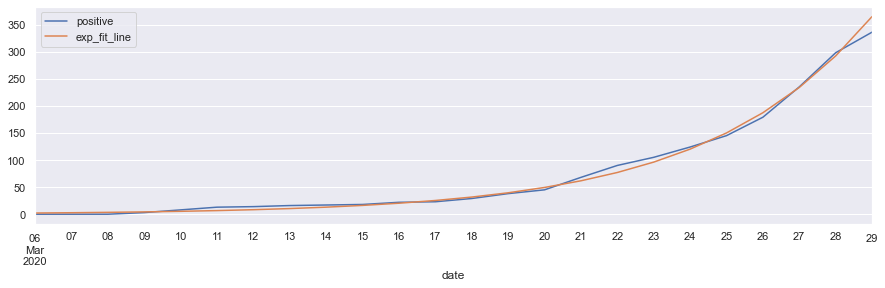

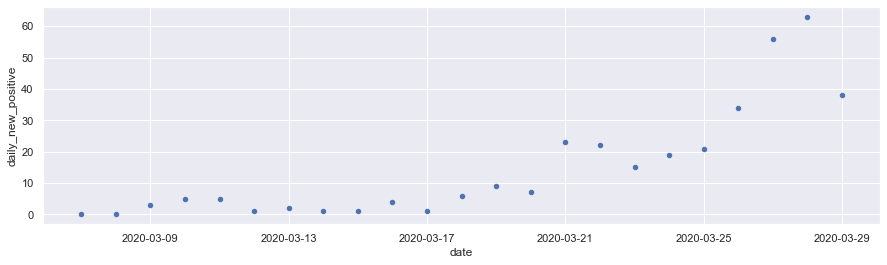

State=KS  (last_update=2020-03-29T11:00)
Doubling every 2.71 days based on last 14 days of data
(naive estimates: current_unresolved=285 hosp=42 icu=11)


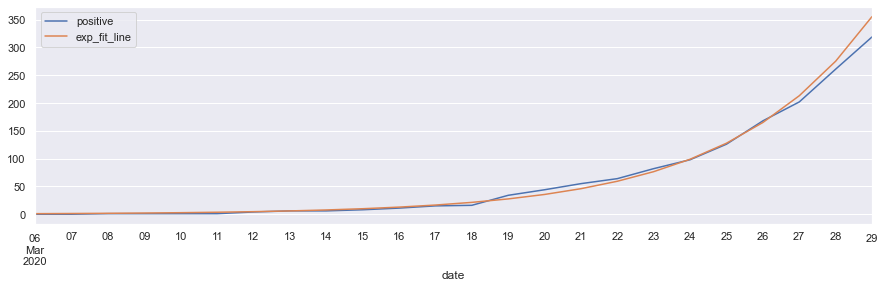

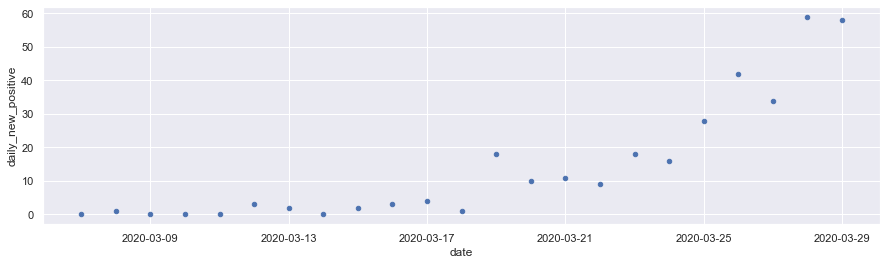

State=RI  (last_update=2020-03-29T12:47)
Doubling every 3.47 days based on last 14 days of data
(naive estimates: current_unresolved=261 hosp=39 icu=10)


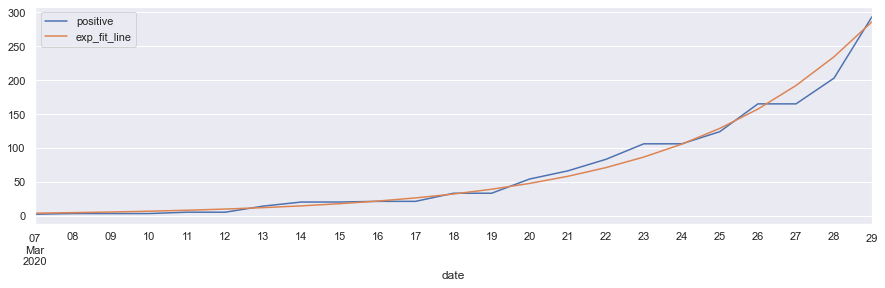

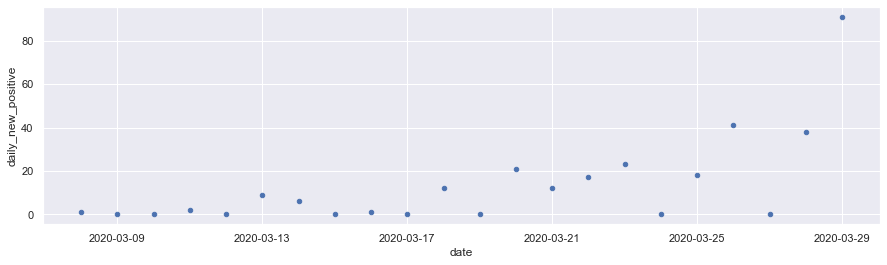

State=ID  (last_update=2020-03-28T18:55)
Doubling every 2.23 days based on last 14 days of data
(naive estimates: current_unresolved=250 hosp=37 icu=10)


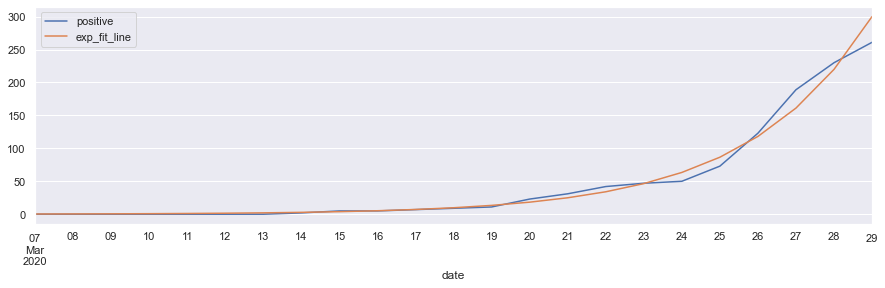

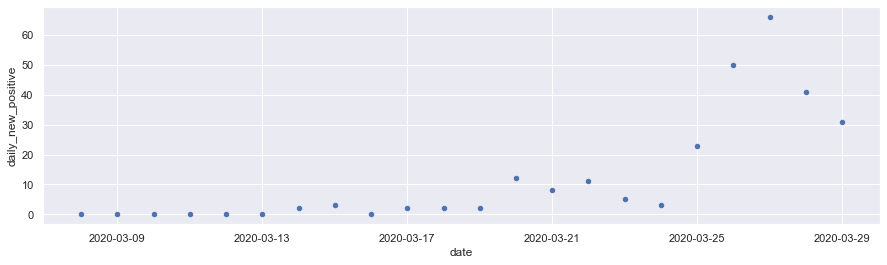

State=ME  (last_update=2020-03-29T14:20)
Doubling every 3.84 days based on last 14 days of data
(naive estimates: current_unresolved=200 hosp=30 icu=8)


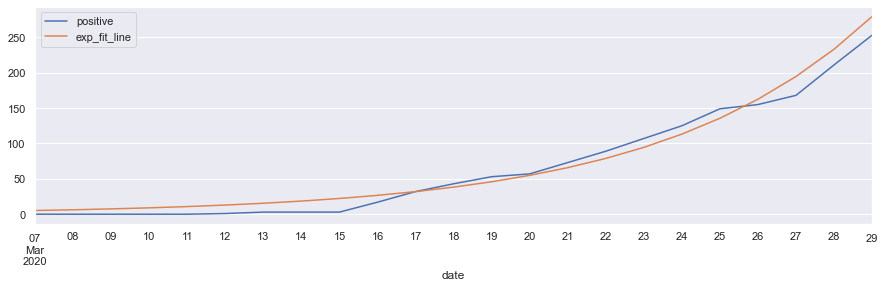

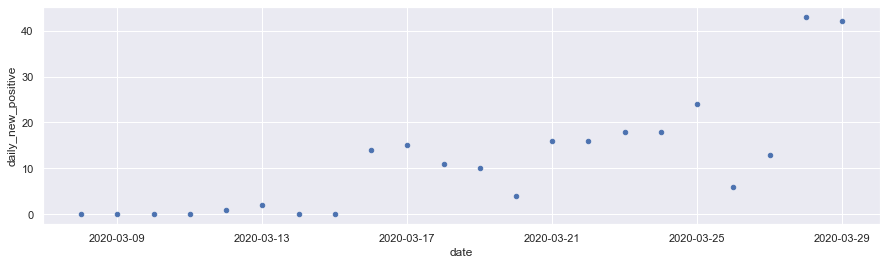

State=NM  (last_update=2020-03-29T00:00)
Doubling every 3.69 days based on last 14 days of data
(naive estimates: current_unresolved=202 hosp=30 icu=8)


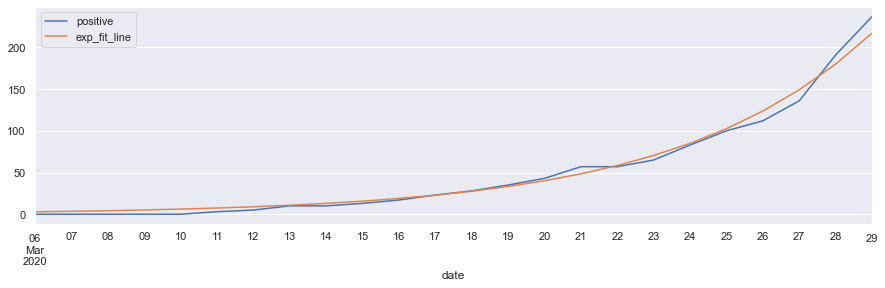

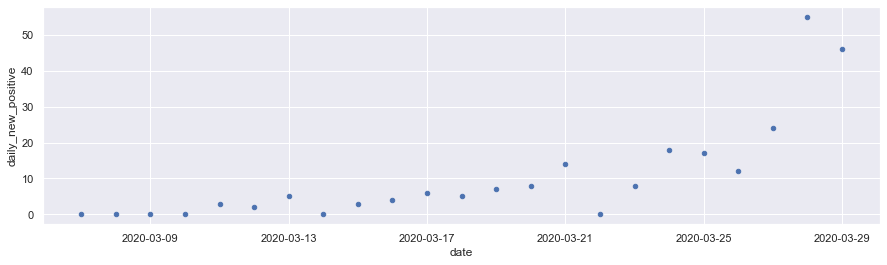

State=VT  (last_update=2020-03-29T13:00)
Doubling every 2.57 days based on last 14 days of data
(naive estimates: current_unresolved=213 hosp=31 icu=8)


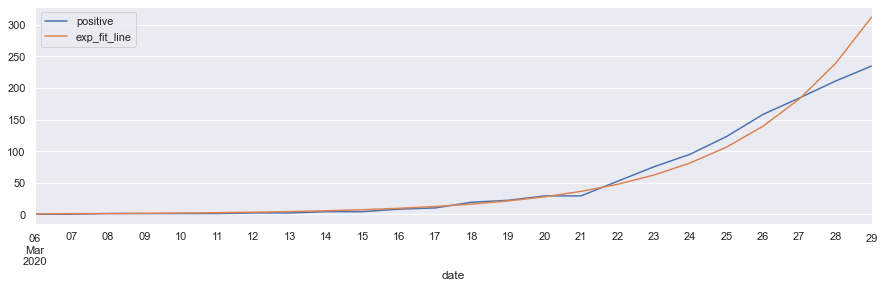

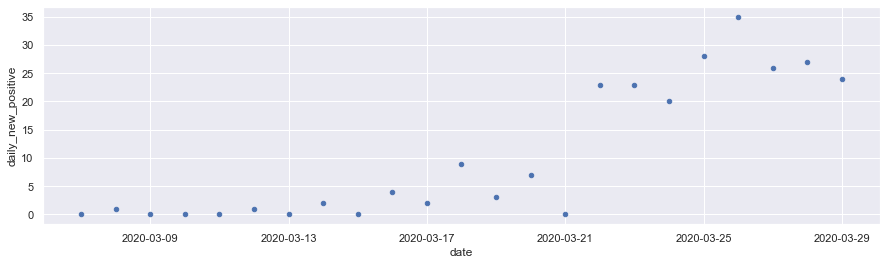

State=DE  (last_update=2020-03-29T00:00)
Doubling every 2.94 days based on last 14 days of data
(naive estimates: current_unresolved=202 hosp=30 icu=8)


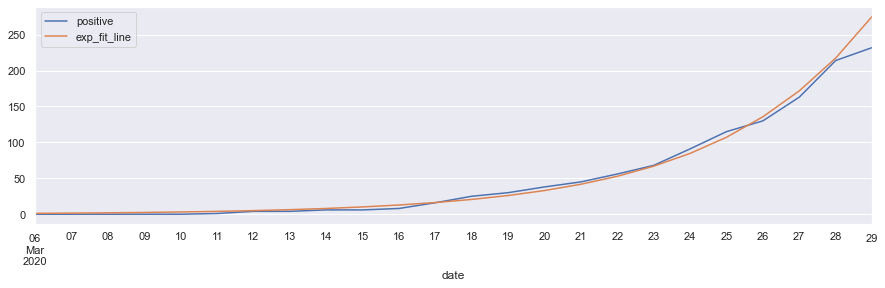

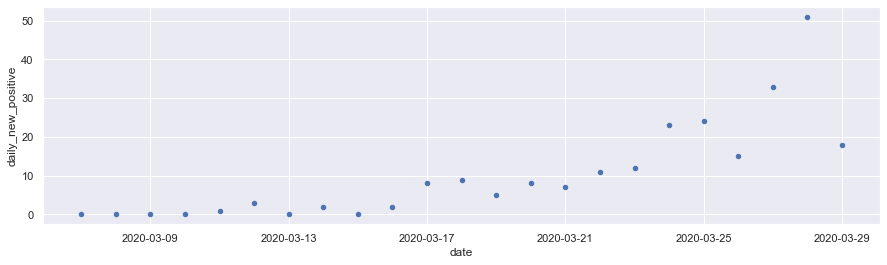

State=NH  (last_update=2020-03-28T09:00)
Doubling every 3.34 days based on last 14 days of data
(naive estimates: current_unresolved=175 hosp=26 icu=7)


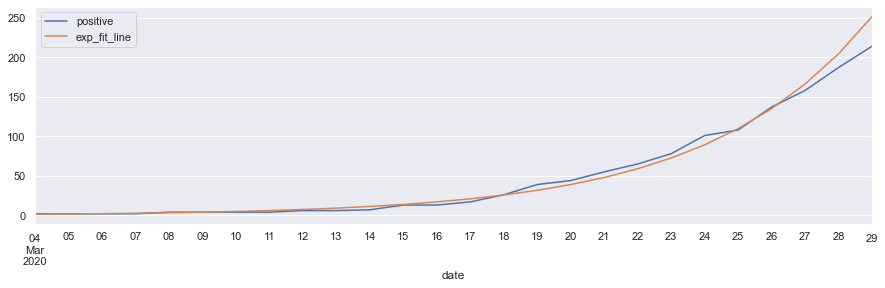

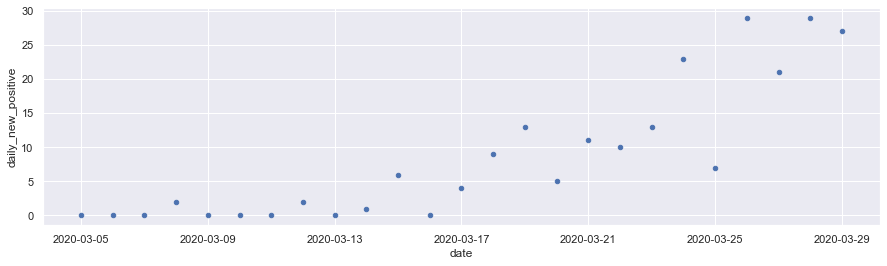

State=MT  (last_update=2020-03-29T10:00)
Doubling every 2.79 days based on last 14 days of data
(naive estimates: current_unresolved=142 hosp=21 icu=5)


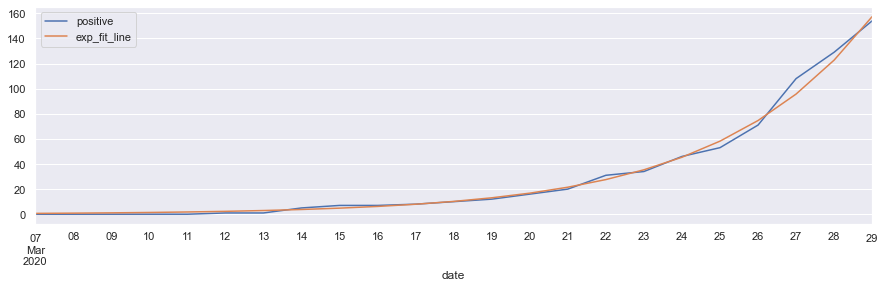

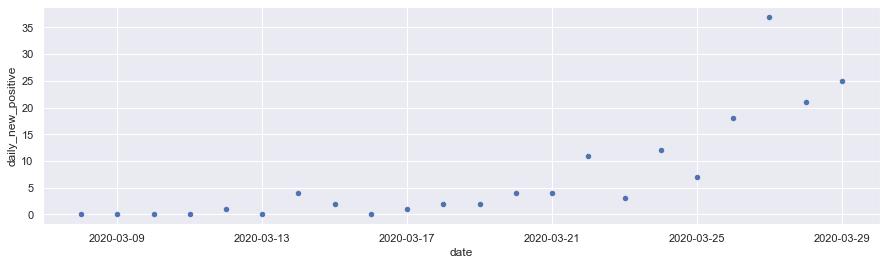

State=HI  (last_update=2020-03-28T18:00)
Doubling every 2.96 days based on last 14 days of data
(naive estimates: current_unresolved=135 hosp=20 icu=5)


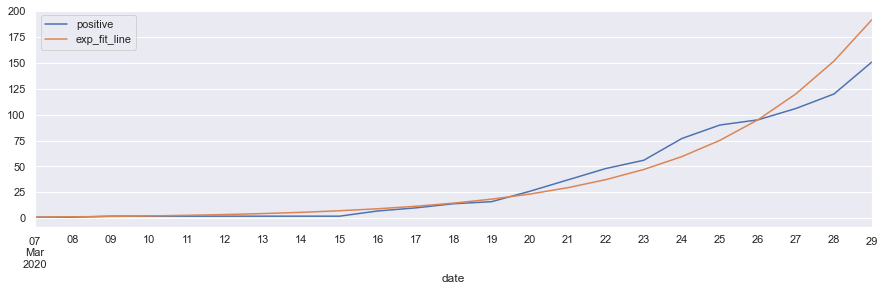

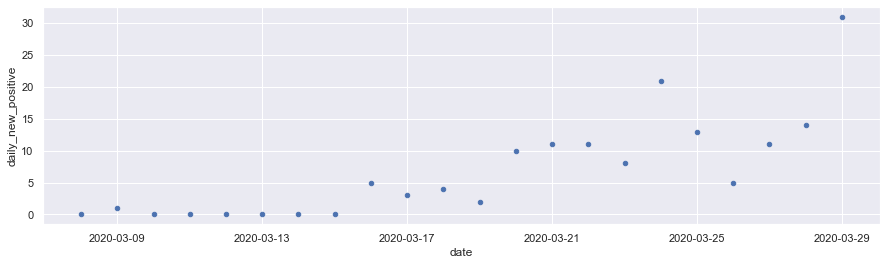

State=PR  (last_update=2020-03-29T07:00)
Doubling every 2.5 days based on last 14 days of data
(naive estimates: current_unresolved=122 hosp=18 icu=4)


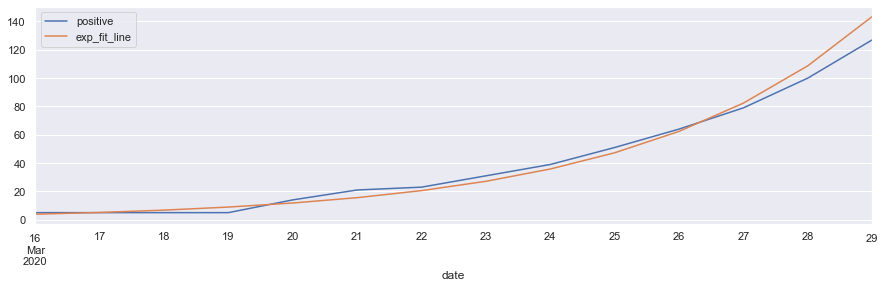

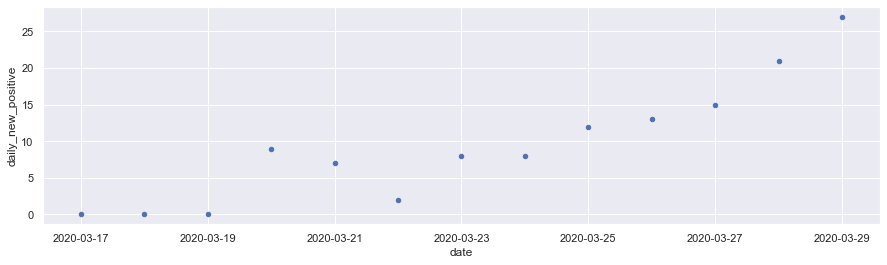

State=WV  (last_update=2020-03-28T00:00)
Doubling every 1.72 days based on last 14 days of data
(naive estimates: current_unresolved=111 hosp=16 icu=4)


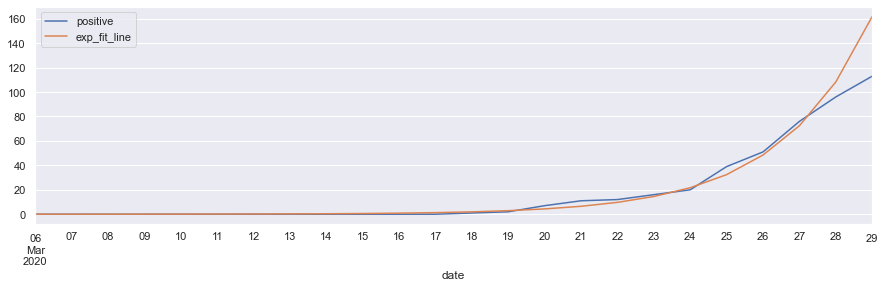

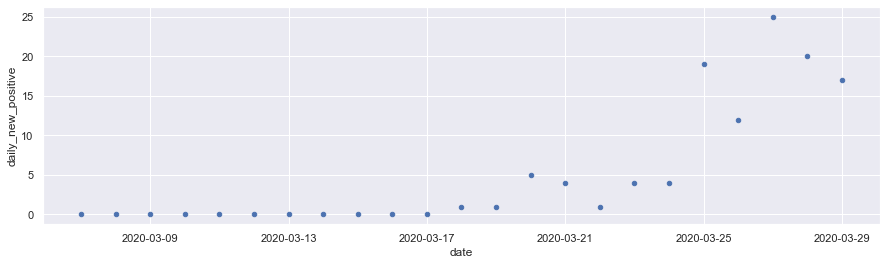

State=NE  (last_update=2020-03-28T20:05)
Doubling every 5.04 days based on last 14 days of data
(naive estimates: current_unresolved=81 hosp=12 icu=3)


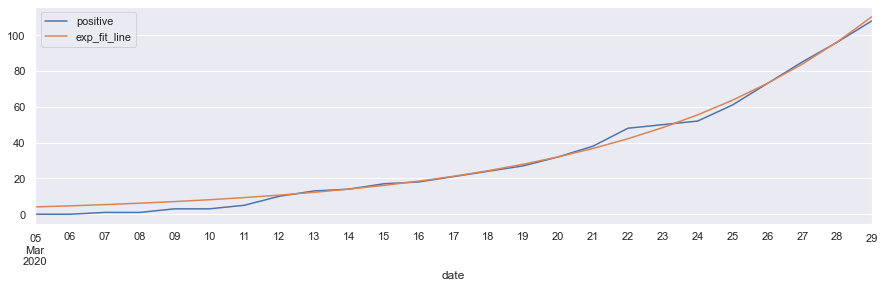

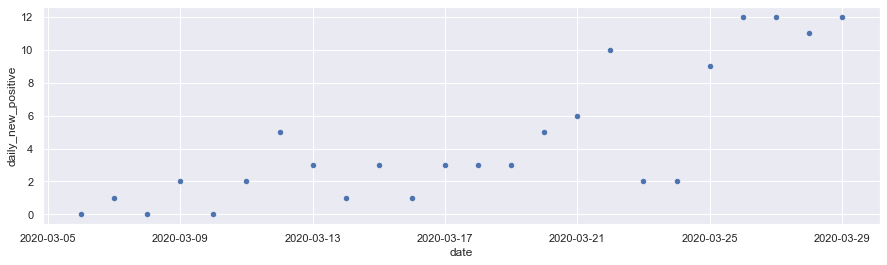

State=AK  (last_update=2020-03-28T19:00)
Doubling every 2.19 days based on last 14 days of data
(naive estimates: current_unresolved=96 hosp=14 icu=3)


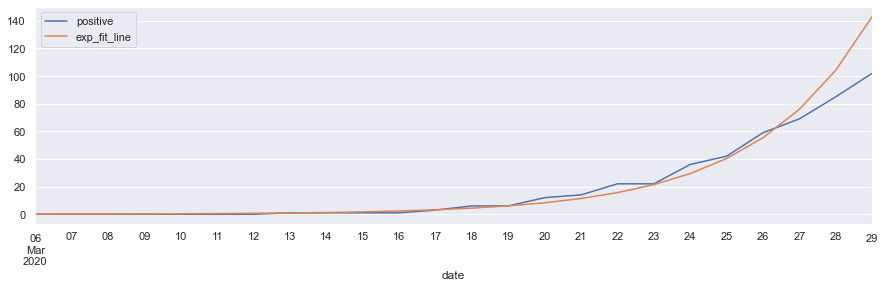

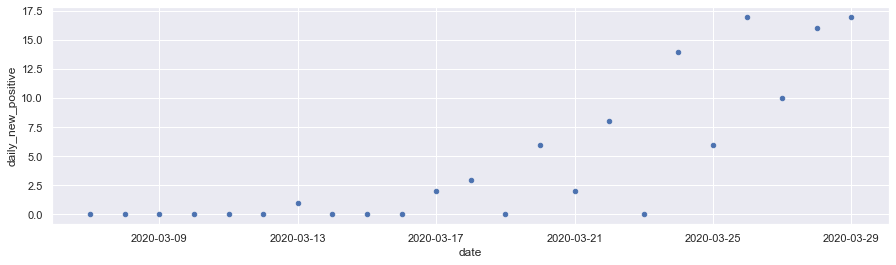

State=ND  (last_update=2020-03-29T12:00)
Doubling every 2.42 days based on last 14 days of data
(naive estimates: current_unresolved=83 hosp=12 icu=3)


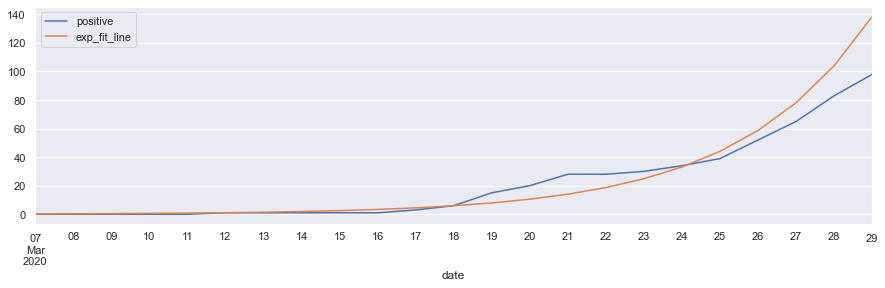

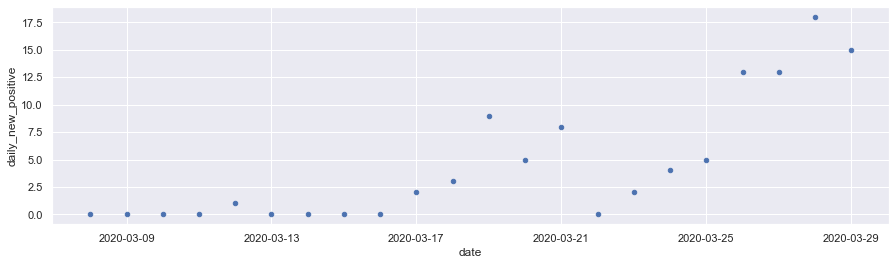

State=SD  (last_update=2020-03-29T12:30)
Doubling every 3.87 days based on last 14 days of data
(naive estimates: current_unresolved=79 hosp=11 icu=3)


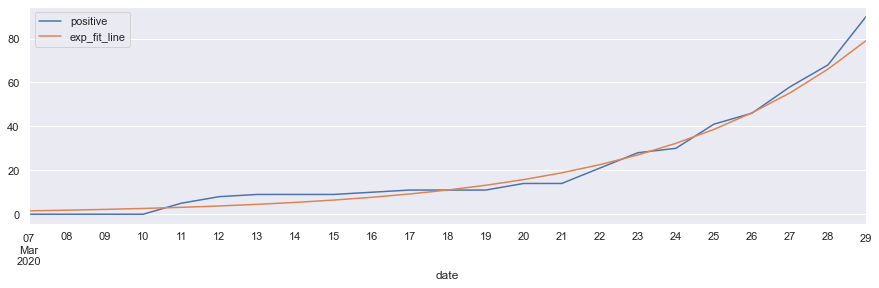

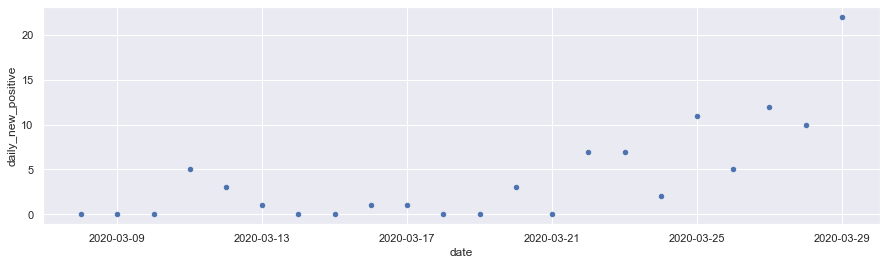

State=WY  (last_update=2020-03-29T00:00)
Doubling every 3.39 days based on last 14 days of data
(naive estimates: current_unresolved=68 hosp=10 icu=2)


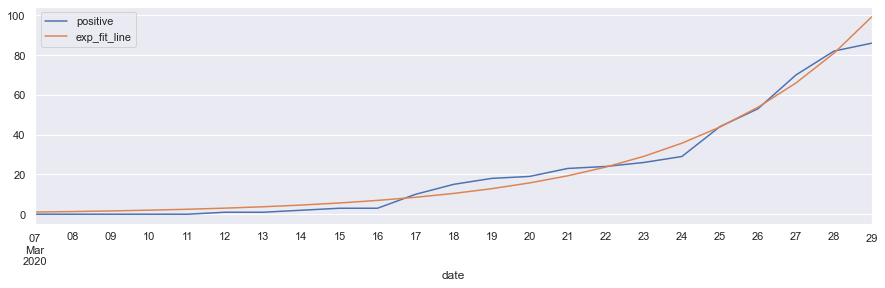

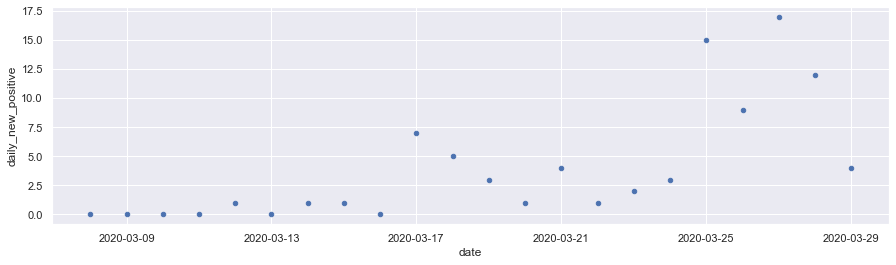

State=GU  (last_update=2020-03-29T04:00)
Doubling every 3.23 days based on last 14 days of data
(naive estimates: current_unresolved=44 hosp=6 icu=1)


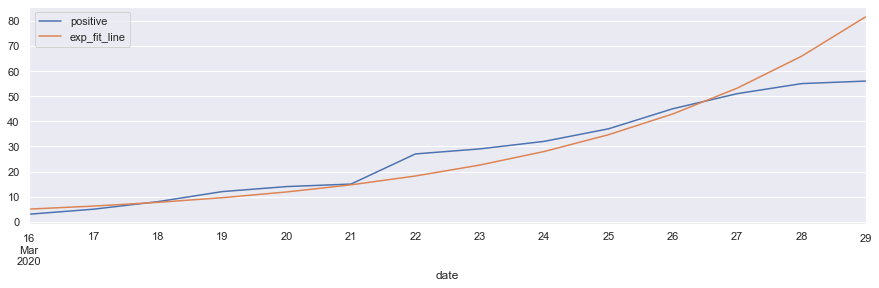

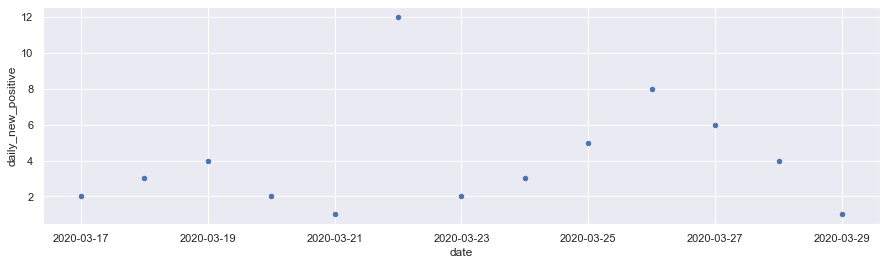

State=VI  (last_update=2020-03-28T19:00)
Doubling every 2.81 days based on last 14 days of data
(naive estimates: current_unresolved=20 hosp=3 icu=0)


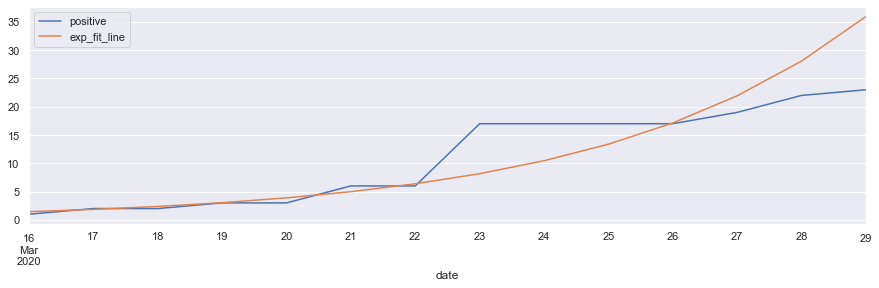

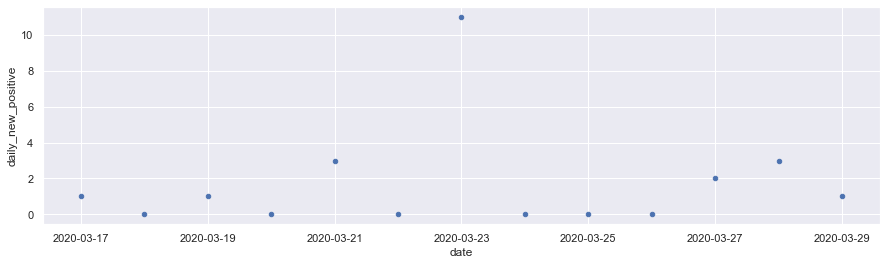

State=MP  (last_update=2020-03-29T01:30)
Doubling every -3.54e+15 days based on last 14 days of data
(naive estimates: current_unresolved=2 hosp=0 icu=0)


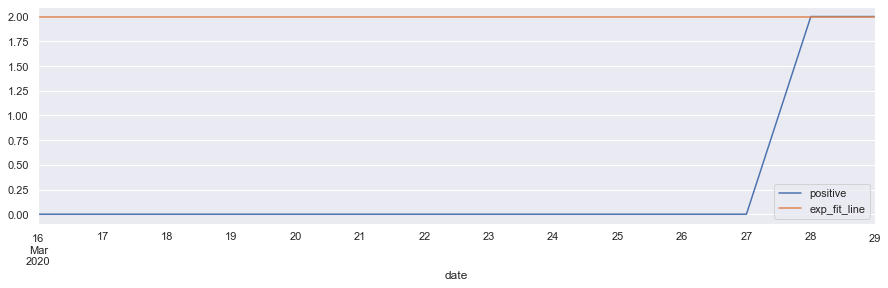

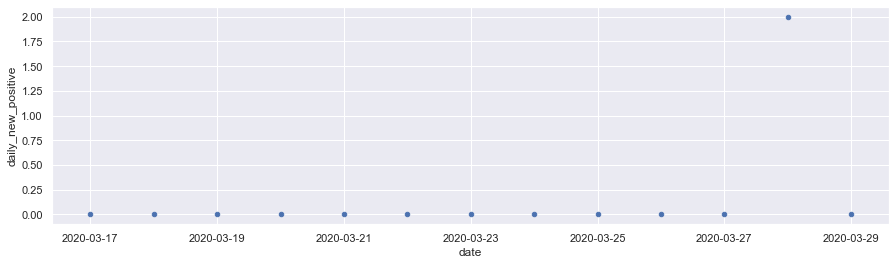

State=AS  (last_update=2020-03-27T00:00)
Doubling every nan days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


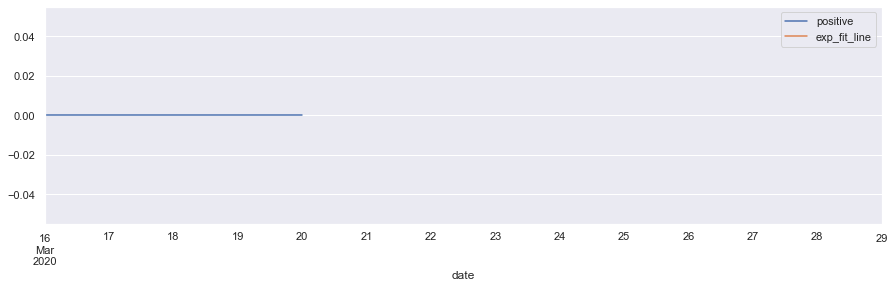

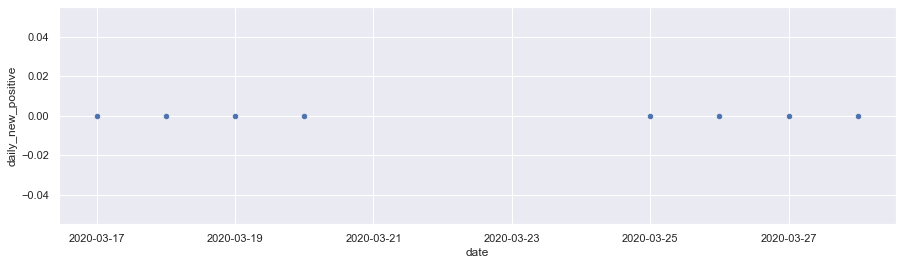

In [13]:
last_n_days = 14
dps = []
for s in states_in_order:
    dfq, dt, lud = get_state_doubling_df(df, s, use_last_n_days=last_n_days)
    dps.append(dt)
    cn, cnh, cni = estimate_current_cases(dfq.daily_new_positive.values)
    lu = str(lud)[:16]
    print("State={}  (last_update={})".format(s, lu))
    print("Doubling every {:.3} days based on last {} days of data".format(dt, last_n_days))
    print("(naive estimates: current_unresolved={} hosp={} icu={})".format(cn, cnh, cni))
    dfq.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
    if len(dfq) > 1:
        dfq.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
    plt.show()

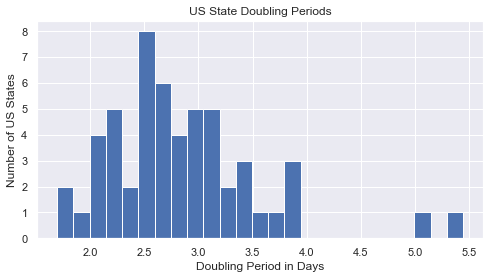

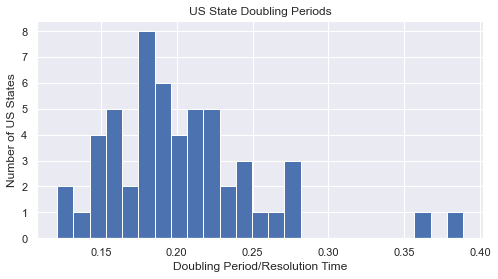

In [14]:
plt.figure(figsize=[8,4])
dps = np.array(dps)
dps = dps[~np.isnan(dps)]
dp_state = dps[dps < 30]
dp_state = dps[dps > 0]
a = plt.hist(dp_state, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period in Days")
plt.ylabel("Number of US States")
plt.show()
# or in terms of resolution time
plt.figure(figsize=[8,4])
resolution_time = 14
a = plt.hist(dp_state/resolution_time, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period/Resolution Time")
plt.ylabel("Number of US States")
plt.show()

### Rolling Doubling Period for US

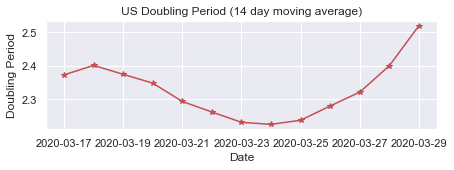

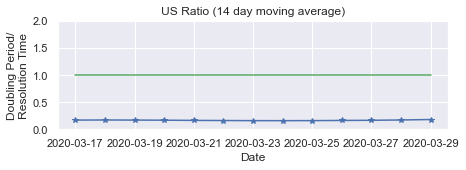

In [15]:
window_size = 14 # days
start_date, end_date = df.date.min(), df.date.max()
delta_t = pd.Timedelta(days=1)
days = int((end_date - start_date).days)
dtv = []
dtt = []
for i in range(days-window_size+2):
    sdt = start_date + i * delta_t
    edt = sdt + window_size * delta_t
    _df = df.loc[(df.date >= sdt) & (df.date < edt)].copy()
    dfa, dt, lud = get_state_doubling_df(_df, "*", use_last_n_days=window_size)
    dtv.append(dt)
    dtt.append(_df.date.values[-1])
plt.figure(figsize=[7,2])
plt.plot(dtt, dtv, "*r-")
plt.title("US Doubling Period ({} day moving average)".format(window_size))
plt.ylabel("Doubling Period")
plt.xlabel("Date")
plt.show()
# by ratio
plt.figure(figsize=[7,2])
plt.plot(dtt, np.array(dtv)/resolution_time, "*b-")
plt.plot(dtt, np.ones(len(dtt)), "g")
plt.title("US Ratio ({} day moving average)".format(window_size))
plt.ylim((0,2))
plt.ylabel("Doubling Period/\nResolution Time")
plt.xlabel("Date")
plt.show()

### Rolling Doubling Period World

In [16]:
def period_factor_plot(dfw, code="CHN", window_size=14, resolution_time=14, ylimit=7):
    dfq, _ = get_state_df(dfw, code)
    try:
        state_name = dfq.Entity.values[0]
    except AttributeError:
        if code == "*":
            state_name = "US"
        else:
            state_name = code
    start_date, end_date = dfq.date.min(), dfq.date.max()
    delta_t = pd.Timedelta(days=1)
    days = int((end_date - start_date).days)
    dtv, dtt = [], []
    for i in range(days-window_size+2):
        sdt = start_date + i * delta_t
        edt = sdt + window_size * delta_t
        _df = dfq.loc[(dfq.date >= sdt) & (dfq.date < edt)].copy()
        dfa, dt, lud = get_state_doubling_df(_df, "*", use_last_n_days=window_size)
        dtv.append(dt)
        dtt.append(_df.date.values[-1])
    plt.figure(figsize=[7,2])
    plt.ylim((0,min([100, 1.1*max(dtv)])))
    plt.plot(dtt, dtv, "*r-")
    plt.title("{} Doubling Period ({} day moving average)".format(state_name, window_size))
    plt.ylabel("Doubling Period")
    plt.xlabel("Date")
    plt.show()
    # by ratio
    plt.figure(figsize=[7,2])
    plt.plot(dtt, np.array(dtv)/resolution_time, "*b-")
    plt.plot(dtt, np.ones(len(dtt)), "g")
    plt.fill_between(dtt, np.ones(len(dtt))*3, np.ones(len(dtt))*5, where=np.ones(len(dtt)), color="yellow", alpha=0.1)
    plt.fill_between(dtt, np.ones(len(dtt))*5, np.ones(len(dtt))*ylimit, where=np.ones(len(dtt)), color="yellow", alpha=0.05)
    plt.fill_between(dtt, np.zeros(len(dtt)), np.ones(len(dtt))*3, where=np.ones(len(dtt)), color="red", alpha=0.1)
    plt.title("{} Ratio ({} day moving average)".format(state_name, window_size))
    plt.ylim((0,ylimit))
    plt.ylabel("Doubling Period/\nResolution Time")
    plt.xlabel("Date")
    plt.show()
    

In [17]:
dfw, wsl = get_world_dataset_df_from_file()
dfw.head()

,Entity,state,Date,positive,date,lastUpdateEt,negative,pending
0,Afghanistan,AFG,"Dec 31, 2019",0,2019-12-31,2020-03-30 01:36:27.444045,0,0
1,Afghanistan,AFG,"Jan 1, 2020",0,2020-01-01,2020-03-30 01:36:27.444045,0,0
2,Afghanistan,AFG,"Jan 2, 2020",0,2020-01-02,2020-03-30 01:36:27.444045,0,0
3,Afghanistan,AFG,"Jan 3, 2020",0,2020-01-03,2020-03-30 01:36:27.444045,0,0
4,Afghanistan,AFG,"Jan 4, 2020",0,2020-01-04,2020-03-30 01:36:27.444045,0,0


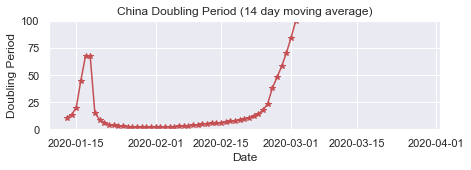

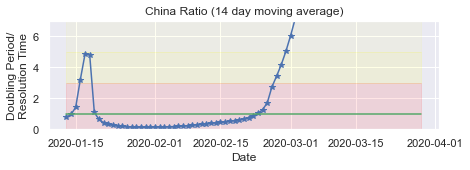

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


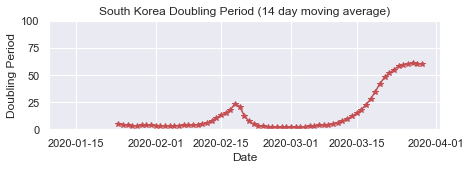

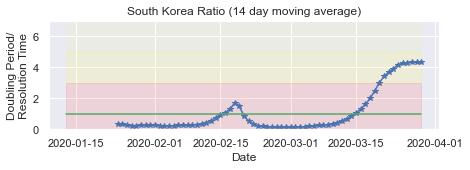

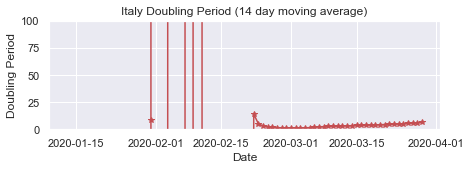

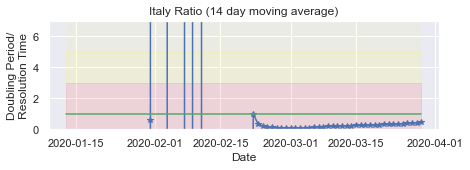

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


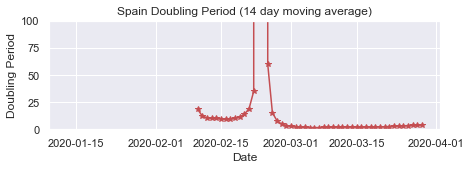

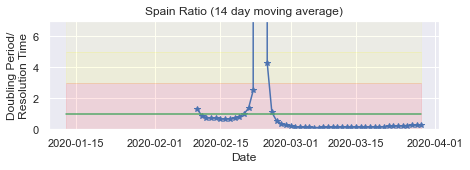

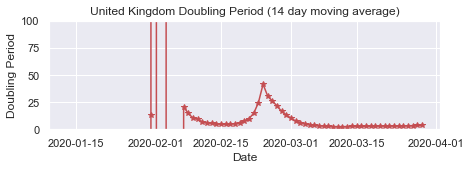

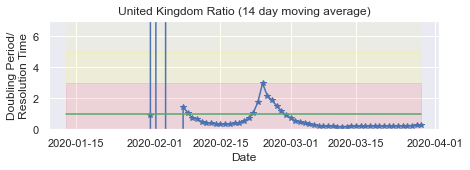

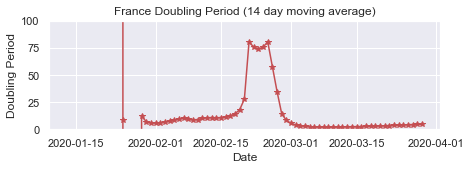

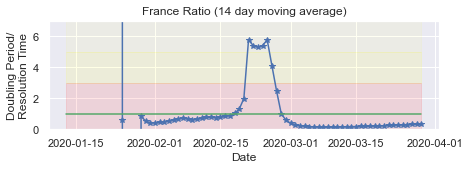

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


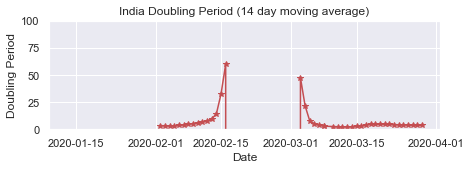

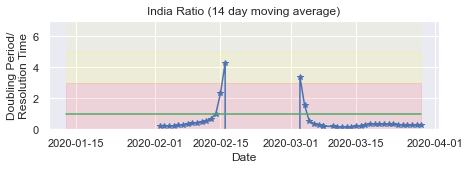

In [18]:
period_factor_plot(dfw,"CHN")
period_factor_plot(dfw,"KOR")
period_factor_plot(dfw,"ITA")
period_factor_plot(dfw,"ESP")
period_factor_plot(dfw,"GBR")
period_factor_plot(dfw,"FRA")
period_factor_plot(dfw,"IND")

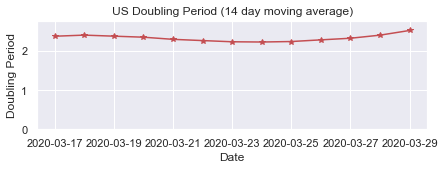

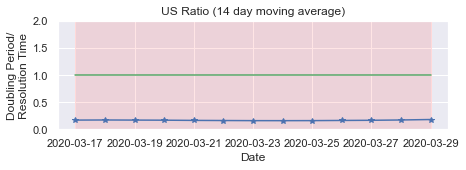

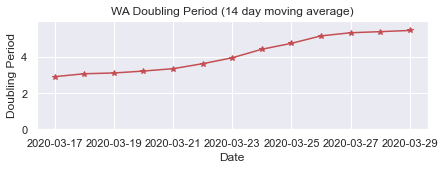

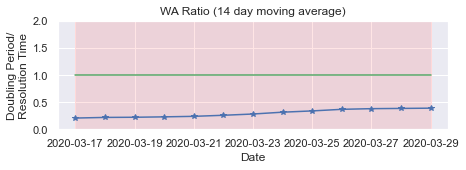

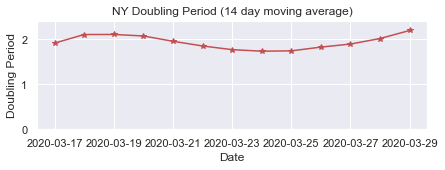

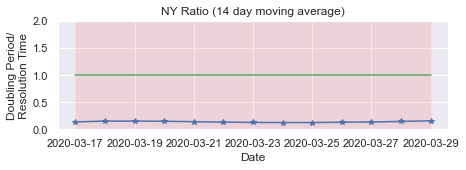

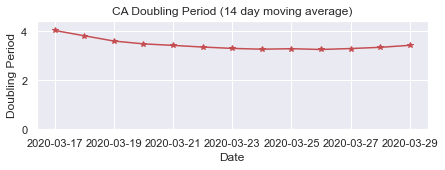

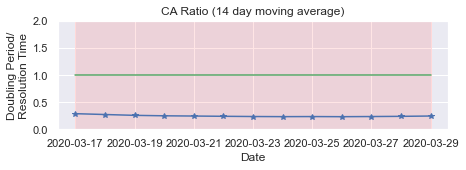

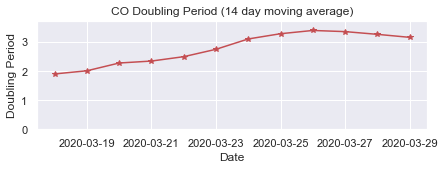

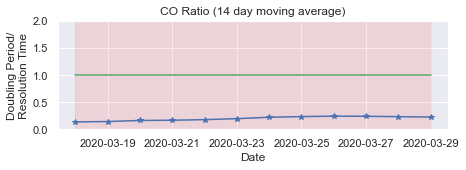

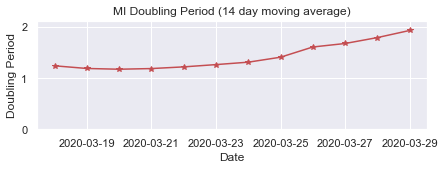

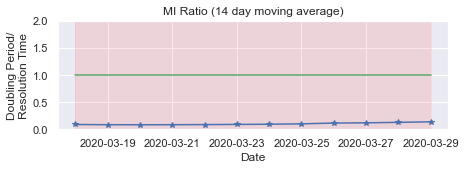

In [19]:
dfw, _ = get_state_df(df, "*")
period_factor_plot(dfw,"*", ylimit=2)
dfw, _ = get_state_df(df, "WA")
period_factor_plot(dfw,"WA", ylimit=2)
dfw, _ = get_state_df(df, "NY")
period_factor_plot(dfw,"NY", ylimit=2)
dfw, _ = get_state_df(df, "CA")
period_factor_plot(dfw,"CA", ylimit=2)
dfw, _ = get_state_df(df, "CO")
period_factor_plot(dfw,"CO", ylimit=2)
dfw, _ = get_state_df(df, "MI")
period_factor_plot(dfw,"MI", ylimit=2)

### Big Grid of Daily Total Cases by State

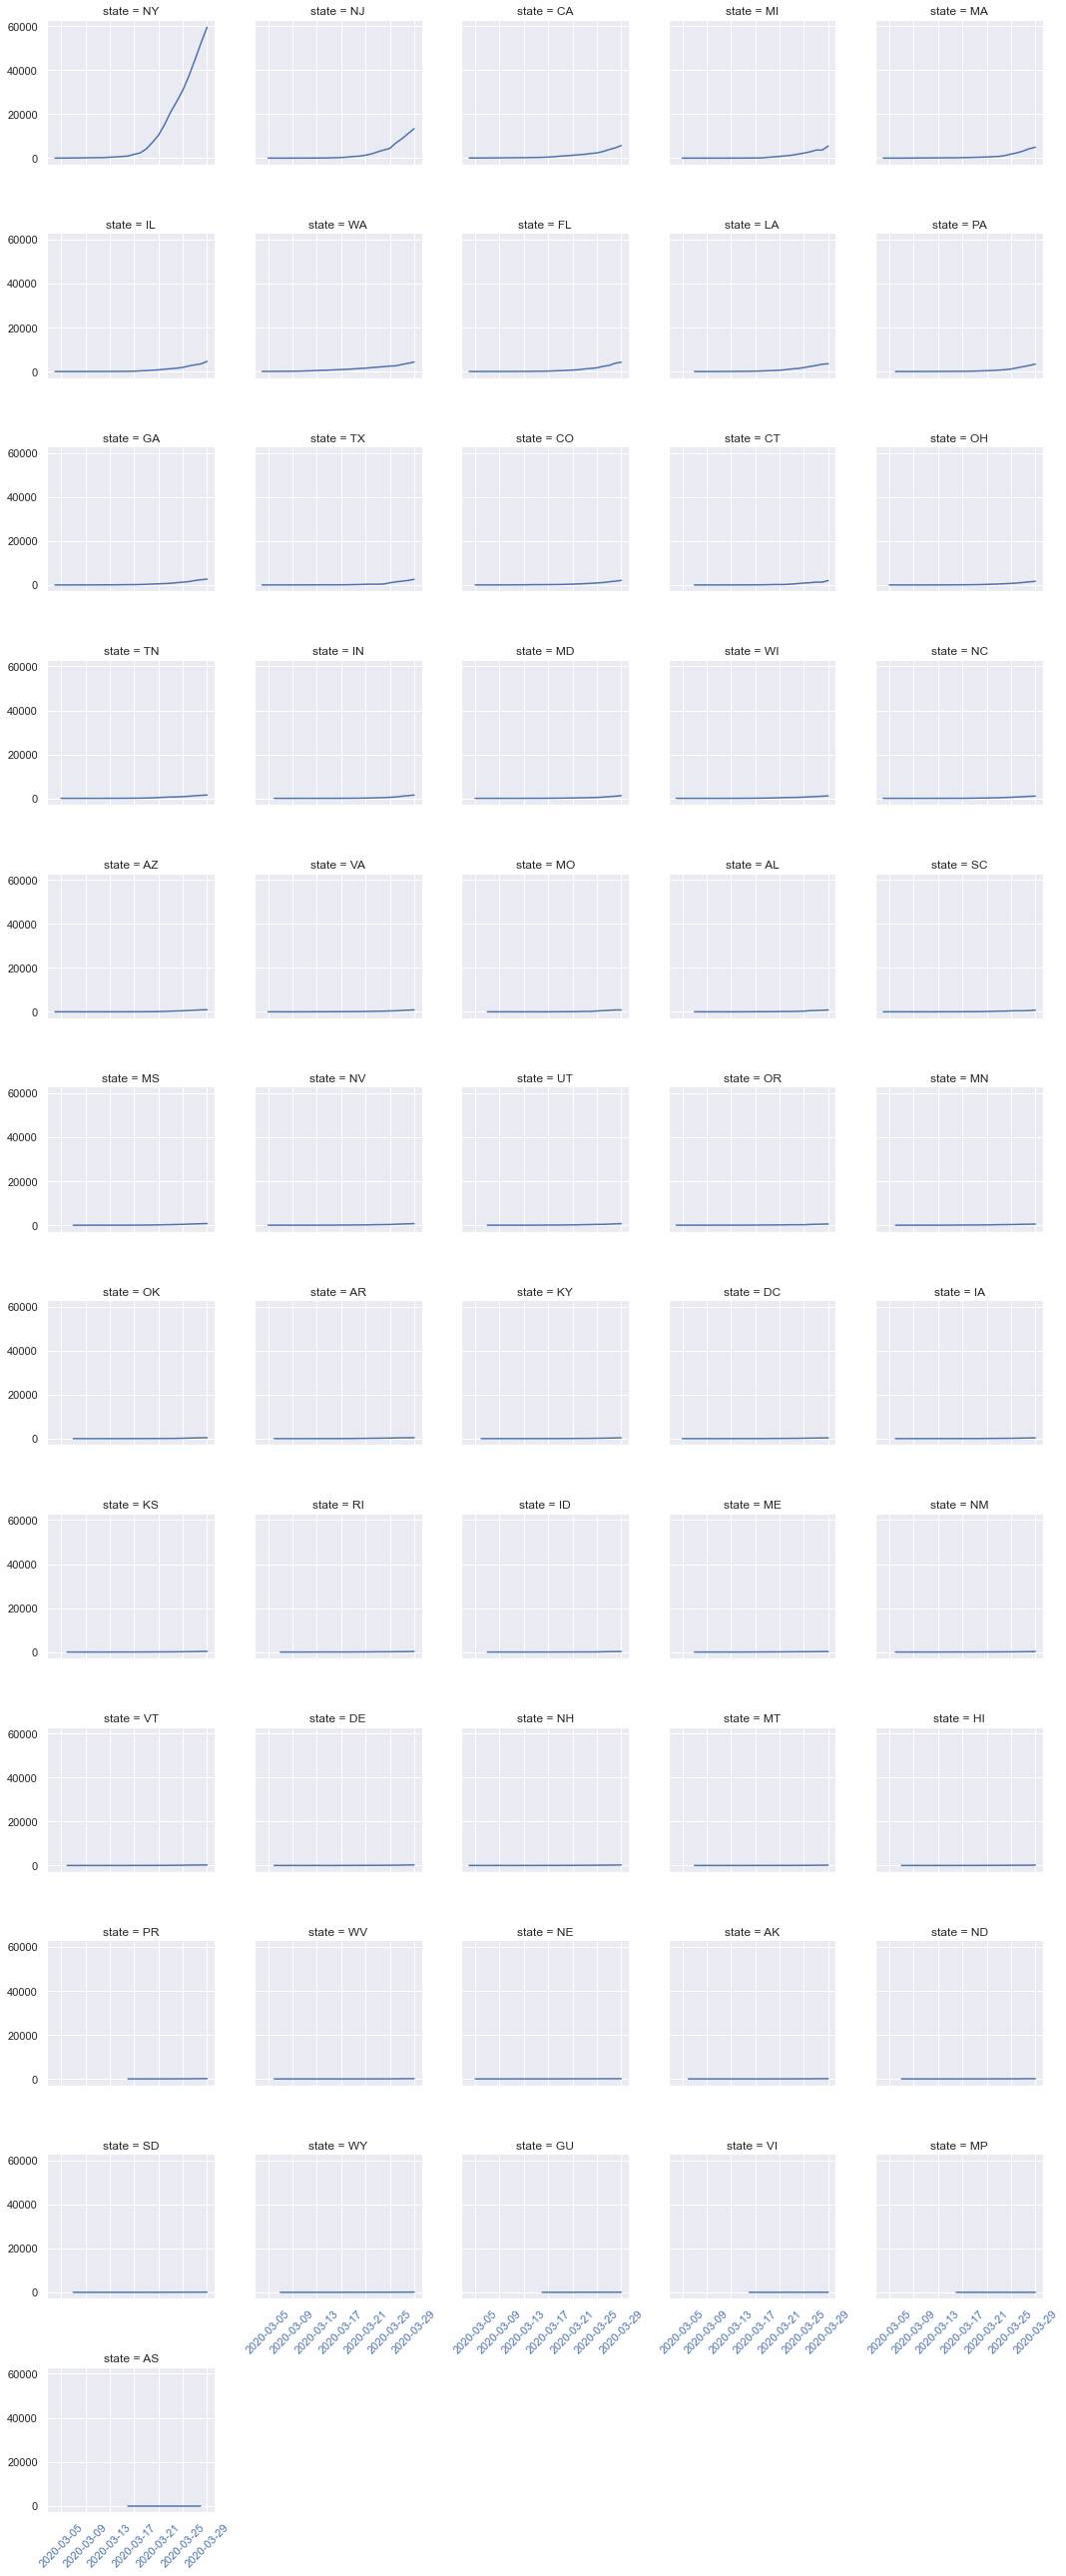

In [20]:
g = sns.FacetGrid(df, col="state", col_wrap=5, height=3, margin_titles=True)
g.map(plt.plot,"date","positive",color="b")
g.map(plt.xticks, rotation=45)